# Imports 

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date,datetime,timedelta
from scipy.spatial.distance import cdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances,pairwise
from sklearn import datasets
import dataframe_image as dfi
import skfuzzy as fuzz
import statistics
%matplotlib inline

# Data preprocessing

In [184]:
#read in Intelliekon data excluding Linz csv file (add path)
df = pd.read_csv("Path to data")

/Users/tamo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [185]:
#List with Fall_ge to connect results with survey data
id_lst = list(df["Fall_ge1"].unique())

### Exclude ids or values

In [186]:
#exclude IDs with unreasonable data
df = df[df["Fall_ge1"]!= 1335]
df = df[df["Fall_ge1"]!= 143]

### Add and convert columns 

In [187]:
#convert "Datum" column to datetime format and ad new "date" and "hour"-column in datetime format
df["datetime"] = pd.to_datetime(df["Datum"],dayfirst = True) + df["Hour_of_Day"].astype("timedelta64[h]")
#df.datetime.dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin") #optional time zone conversion

#df["date"]= df['datetime'].apply(lambda x: x.date)
df["day_of_year"] = df["datetime"].apply(lambda x: x.timetuple().tm_yday)
df["hour"]= df['datetime'].apply(lambda x: x.hour)

### Normalisation 

In [188]:
#choice of normalization technique:

#normalisation with max electricity demand of the time series:
df['max_energy'] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(max)
df["min_energy"] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(min)
df['norm_energy'] = (df['Electricity_Demand']-df["min_energy"]) / (df['max_energy']-df["min_energy"])

#normalisation based on the maximum value of each day:
#df["max_energy"] = df.groupby(["Fall_ge1","Datum"])["Electricity_Demand"].transform(max)
#df["min_energy"] = df.groupby(['Fall_ge1',"Datum"])['Electricity_Demand'].transform(min)
#df['norm_energy'] = (df['Electricity_Demand']-df["min_energy"]) / (df['max_energy']-df["min_energy"])
#Test: df[(df["Fall_ge1"]== 636) & (df["day_of_year"]== 280)]

In [189]:
#funktion for plotting mean of different cities to compare them
def mean_plot (df,String):
    red_df=df[["hour","norm_energy"]]
    plt.plot(red_df.groupby("hour").mean(), label ="mean")
    plt.legend()
    plt.title("Mean with ")

## Create dataframes for different seasons

In [191]:
    #Meteorological seasons:
    #winter
    sdate_wi = date(2009, 12, 1)   # start date
    edate_wi = date(2010, 2, 28)   # end date
    #spring
    sdate_sp = date(2010, 3, 1)   # start date
    edate_sp = date(2010, 5, 31)   # end date
    #summer
    sdate_su = date(2010, 6, 1)   # start date
    edate_su = date(2010, 8, 31)   # end date
    #Fall
    sdate_fa = date(2009, 9, 1)   # start date
    edate_fa = date(2009, 11, 30)   # end date
    

In [10]:
    #filter df by season:
    df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
    df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
    df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
    df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]

In [11]:
    #split weekend/week
    df_fa_week=df_fa[df_fa["Weekday"]==1]
    df_fa_wknd=df_fa[df_fa["Weekday"]==2]
    df_wi_week=df_wi[df_wi["Weekday"]==1]
    df_wi_wknd=df_wi[df_wi["Weekday"]==2]
    df_sp_week=df_sp[df_sp["Weekday"]==1]
    df_sp_wknd=df_sp[df_sp["Weekday"]==2]
    df_su_week=df_su[df_su["Weekday"]==1]
    df_su_wknd=df_su[df_su["Weekday"]==2]

In [12]:
#df.set_index("datetime", inplace = True)

In [13]:
#shape of seasonal dataframes to check if they contain a simmilar number of values
df_su.shape

(1068984, 19)

In [14]:
df_wi.shape

(897768, 19)

In [15]:
df_fa.shape

(871104, 19)

In [16]:
df_sp.shape

(1027608, 19)

# Functions for K-means clustering

In [17]:
#split dataframes into weekday and weekend days for different locations
def split_df(df,string):
    
    df = df[df["Daten_Herkunft"]== string]
    #Meteorological seasons:
    #winter
    sdate_wi = date(2009, 12, 1)   # start date
    edate_wi = date(2010, 2, 28)   # end date
    #spring
    sdate_sp = date(2010, 3, 1)   # start date
    edate_sp = date(2010, 5, 31)   # end date
    #summer
    sdate_su = date(2010, 6, 1)   # start date
    edate_su = date(2010, 8, 31)   # end date
    #Fall
    sdate_fa = date(2009, 9, 1)   # start date
    edate_fa = date(2009, 11, 30)   # end date
    
    #filter df by season:
    df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
    df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
    df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
    df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]
    
    #split weekend/week
    df_fa_week=df_fa[df_fa["Weekday"]==1]
    df_fa_wknd=df_fa[df_fa["Weekday"]==2]
    df_wi_week=df_wi[df_wi["Weekday"]==1]
    df_wi_wknd=df_wi[df_wi["Weekday"]==2]
    df_sp_week=df_sp[df_sp["Weekday"]==1]
    df_sp_wknd=df_sp[df_sp["Weekday"]==2]
    df_su_week=df_su[df_su["Weekday"]==1]
    df_su_wknd=df_su[df_su["Weekday"]==2]
    
    return df_fa_week, df_fa_wknd, df_wi_week, df_wi_wknd, df_sp_week, df_sp_wknd, df_su_week, df_su_wknd

In [18]:
#multiline plot for cluster visualization (adaption needed):
def multiline_hourly_plot(dataset, avg = None, ycol = 'Electricity_Demand', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()
    
    return fig

In [19]:
#function for ploting a multiline plot for every cluster (adaption needed)
def clusters_visualisation(grp_df, id_vars, value_vars):
    melt_df_x = grp_df.copy()
    #if "cluster" in melt_df_x:
    #    del melt_df_x["cluster"]
    melt_df = pd.melt(melt_df_x, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = grp_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [20]:
#function for cluster validation scores
def cluster_validation(df,clustering):
    labels = clustering.labels_
    sil_coef = metrics.silhouette_score(df, labels, metric='euclidean')
    cal_har = metrics.calinski_harabasz_score(df, labels)
    db_ind = metrics.davies_bouldin_score(df, labels)
    coef_df = pd.DataFrame([[sil_coef,cal_har,db_ind]], columns = ["Silhouette","Calinski-Harabasz","Davies-Bouldin"])
    return coef_df

In [21]:
#Main function for the K-Means algorithm: plots elbow plot, plots cluster centers with cluster member number, plots clustering results for all the locations 
def elbow_method(dataframe, min_k, max_k,season,week,clust_coef,center_df):
    
    #reshape input df for clustering algorithm
    red_df=dataframe[["Fall_ge1","day_of_year","hour","norm_energy"]]
    piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
    piv_df.reset_index(inplace = True)
    grp_df = piv_df.groupby("Fall_ge1").mean()
    #grp_df.reset_index(inplace = True)
    del grp_df["day_of_year"]
    kmeans_df = grp_df
    #check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
    if "cluster" in kmeans_df:
        del kmeans_df["cluster"]
    
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k,n_init=50,max_iter=400) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(kmeans_df) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(kmeans_df, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    #use sil coef for decicion making with the optimum cluster number (adaption needed)
    #labels_sil = [k_mean_res[x].labels_ for x in range(2,20)]
    #calulate sil_coef
    #sil_coef = [metrics.silhouette_score(kmeans_df, labels_sil, metric='euclidean') for centroid in centroids]
    
#     #Plot graph with silhouette coef (adaption needed)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(cluster_nums, sil_coef, 'g*-')
#     plt.grid(True)
#     plt.xlabel('Number of clusters')
#     plt.ylabel('silhouette Coefficient')
#     plt.show()
    
    algorithm = k_mean_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 5 corresponds to the element with index 3
    clustering = k_mean_res[3]
    
    #reassign cluster numbers so the cluster numbers are from lowest to highest mean
    k=5
    
    #order of clustering centers by mean (idx)
    idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
    
    #"key" to convert count from 1 to 5 to the order regarding the mean (lut)
    lut = np.zeros_like(idx)
    
    lut[idx] = np.arange(k)
    
    #assign cluster labels odered by mean to dataframe
    kmeans_df['cluster'] = list(lut[clustering.labels_])
    
    #order clustering centers by mean
    clust_cent = clustering.cluster_centers_[idx]
    
    #plot clustering centers with normalized consumption
    for x in range(0,5,1):
        plt.plot(clust_cent[x],label = "Cluster " + str(x))  
        plt.legend(loc = 'upper left')
        plt.title(season + " " + week)
        plt.ylabel("Normalized consumption")
        plt.xlabel("Hours of the day")
        
    #print number of household Ids per cluster
    for x in range(0,5,1):
        num_hh = kmeans_df[kmeans_df["cluster"]==x].index.nunique()
        print("Cluster " +str(x) + " has " + str(num_hh) + " clustering members")
    
    ## optional: print ids that have the same cluster membership
    print(str(kmeans_df[kmeans_df["cluster"]==4].index.unique()))
        
    #Multilineplot (optional)
    #kmeans_df['Fall_ge1'] = kmeans_df.index
    #clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
    
    #calculate the validation indices and append to clust_coef(df that is input to the function)      
    labels = clustering.labels_
    sil_coef = metrics.silhouette_score(kmeans_df, labels, metric='euclidean')
    cal_har = metrics.calinski_harabasz_score(kmeans_df, labels)
    db_ind = metrics.davies_bouldin_score(kmeans_df, labels)
    coef_df = pd.DataFrame([[sil_coef,cal_har,db_ind]], columns = ["Silhouette","Calinski-Harabasz","Davies-Bouldin"])
    clust_valid = clust_coef.append(coef_df,ignore_index = True)
    
    #dataframe that collects the clustering centers; reshaping for comparing over all clustering similarity
    clust_cent_df = pd.DataFrame(data = clust_cent.reshape(1,120))
    
    #append centers to create a df with all clustering centers for all locations
    center_df = center_df.append(clust_cent_df, ignore_index = True)
    
    return clust_valid,center_df
    #return (k_mean_algs, k_mean_res) 
    #return distances

In [22]:
#Initalize a df where all the cluster validation idices are saved
clust_coef = pd.DataFrame(columns = ["Silhouette","Calinski-Harabasz","Davies-Bouldin"])

In [23]:
#Initialize df with all cluster centers
clust_cent_df = pd.DataFrame()

In [24]:
center_df = pd.DataFrame()

In [25]:
center_df_fa_wk = pd.DataFrame()

In [26]:
#compare number of hourly values for the different locations
df.Daten_Herkunft.value_counts()

Krefeld           1082016
Kaiserslautern    1054872
Münster            830016
Ulm                795312
Hassfurt           737880
Schwerte           693792
Celle              590928
Name: Daten_Herkunft, dtype: int64

## Create dataframes from different locations

In [27]:
df_fa_week_kre, df_fa_wknd_kre, df_wi_week_kre, df_wi_wknd_kre, df_sp_week_kre, df_sp_wknd_kre, df_su_week_kre, df_su_wknd_kre = split_df(df,"Krefeld")

In [28]:
df_fa_week_mue, df_fa_wknd_mue, df_wi_week_mue, df_wi_wknd_mue, df_sp_week_mue, df_sp_wknd_mue, df_su_week_mue, df_su_wknd_mue = split_df(df,"Münster")

In [29]:
df_fa_week_schw, df_fa_wknd_schw, df_wi_week_schw, df_wi_wknd_schw, df_sp_week_schw, df_sp_wknd_schw, df_su_week_schw, df_su_wknd_schw = split_df(df,"Schwerte")

In [30]:
df_fa_week_ulm, df_fa_wknd_ulm, df_wi_week_ulm, df_wi_wknd_ulm, df_sp_week_ulm, df_sp_wknd_ulm, df_su_week_ulm, df_su_wknd_ulm = split_df(df,"Ulm")

In [31]:
df_fa_week_kai, df_fa_wknd_kai, df_wi_week_kai, df_wi_wknd_kai, df_sp_week_kai, df_sp_wknd_kai, df_su_week_kai, df_su_wknd_kai = split_df(df,"Kaiserslautern")

In [32]:
df_fa_week_cel, df_fa_wknd_cel, df_wi_week_cel, df_wi_wknd_cel, df_sp_week_cel, df_sp_wknd_cel, df_su_week_cel, df_su_wknd_cel = split_df(df,"Celle")

In [33]:
df_fa_week_hass, df_fa_wknd_hass, df_wi_week_hass, df_wi_wknd_hass, df_sp_week_hass, df_sp_wknd_hass, df_su_week_hass, df_su_wknd_hass = split_df(df,"Hassfurt")

In [34]:
#df_fa_week_oel, df_fa_wknd_oel, df_wi_week_oel, df_wi_wknd_oel, df_sp_week_oel, df_sp_wknd_oel, df_su_week_oel, df_su_wknd_oel = split_df(df,"Oelde")

# Clustering results for the different time periods: 

# Fall

### Fall weekday 

In [35]:
#initiate df for the clustering centers
center_df_fa_week =pd.DataFrame()

In [36]:
#list for for-loop with all the locations
lst_fa_week = [df_fa_week,df_fa_week_kre,df_fa_week_mue,df_fa_week_schw,df_fa_week_ulm,df_fa_week_kai,df_fa_week_cel,df_fa_week_hass]

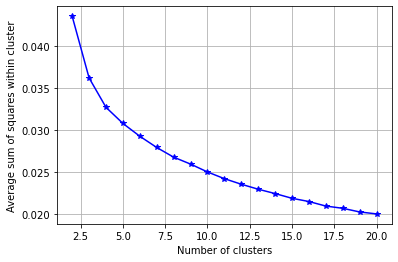

Cluster 0 has 138 clustering members
Cluster 1 has 164 clustering members
Cluster 2 has 83 clustering members
Cluster 3 has 86 clustering members
Cluster 4 has 41 clustering members
Int64Index([  13,  104,  147,  178,  261,  469,  480,  547,  558,  563,  581,
             602,  614,  627,  637,  643,  649,  655,  684,  691,  692,  693,
             701, 1007, 1013, 1022, 1094, 1193, 1306, 1310, 1313, 1314, 1317,
            1319, 1325, 1330, 1333, 1340, 1354, 1358, 1361],
           dtype='int64', name='Fall_ge1')


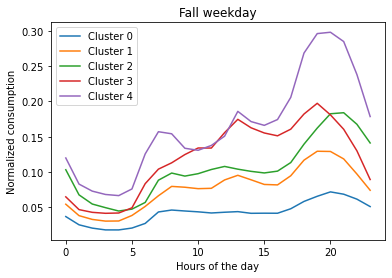

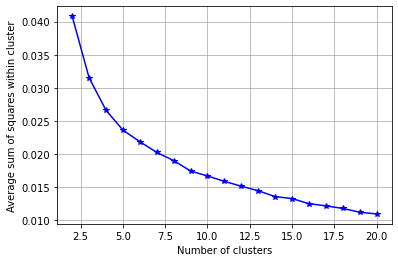

Cluster 0 has 16 clustering members
Cluster 1 has 39 clustering members
Cluster 2 has 13 clustering members
Cluster 3 has 16 clustering members
Cluster 4 has 3 clustering members
Int64Index([13, 1007, 1013], dtype='int64', name='Fall_ge1')


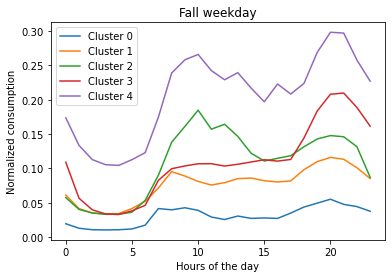

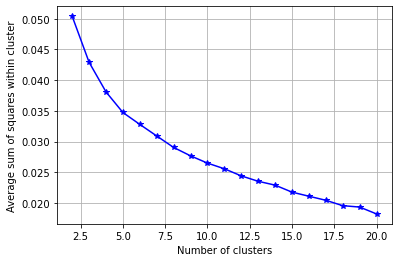

Cluster 0 has 32 clustering members
Cluster 1 has 32 clustering members
Cluster 2 has 25 clustering members
Cluster 3 has 19 clustering members
Cluster 4 has 9 clustering members
Int64Index([558, 602, 637, 655, 692, 1317, 1319, 1325, 1354], dtype='int64', name='Fall_ge1')


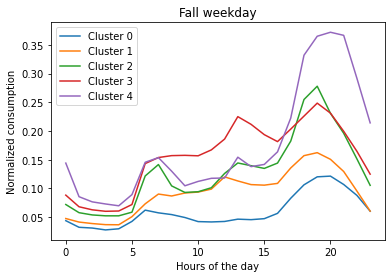

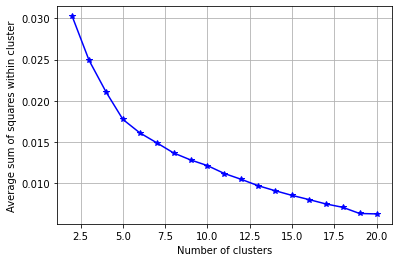

Cluster 0 has 12 clustering members
Cluster 1 has 16 clustering members
Cluster 2 has 17 clustering members
Cluster 3 has 6 clustering members
Cluster 4 has 2 clustering members
Int64Index([104, 147], dtype='int64', name='Fall_ge1')


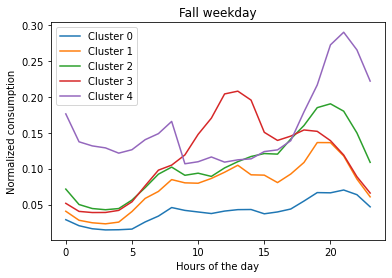

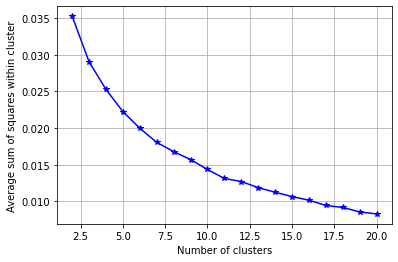

Cluster 0 has 19 clustering members
Cluster 1 has 18 clustering members
Cluster 2 has 14 clustering members
Cluster 3 has 9 clustering members
Cluster 4 has 2 clustering members
Int64Index([157, 178], dtype='int64', name='Fall_ge1')


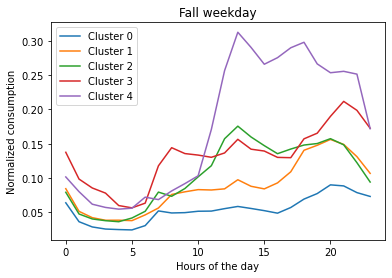

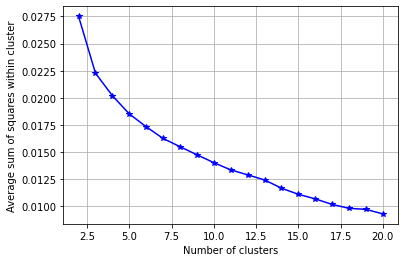

Cluster 0 has 23 clustering members
Cluster 1 has 39 clustering members
Cluster 2 has 10 clustering members
Cluster 3 has 13 clustering members
Cluster 4 has 15 clustering members
Int64Index([ 322,  339,  376,  381,  387, 1166, 1171, 1172, 1176, 1181, 1189,
            1191, 1193, 1202, 1204],
           dtype='int64', name='Fall_ge1')


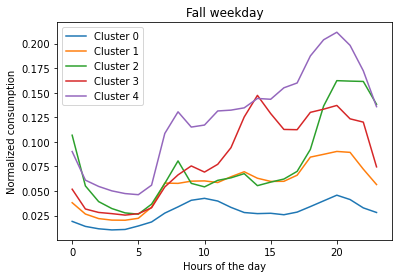

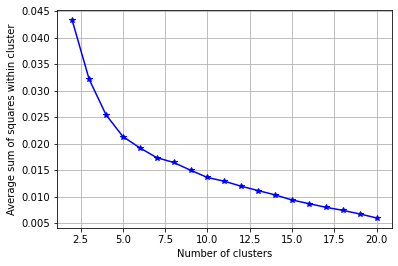

Cluster 0 has 15 clustering members
Cluster 1 has 22 clustering members
Cluster 2 has 9 clustering members
Cluster 3 has 1 clustering members
Cluster 4 has 1 clustering members
Int64Index([480], dtype='int64', name='Fall_ge1')


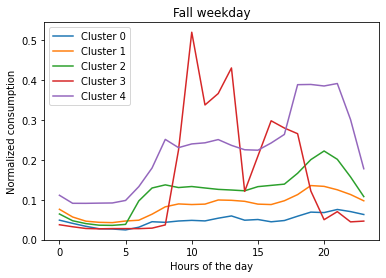

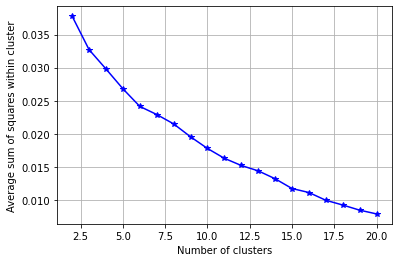

Cluster 0 has 6 clustering members
Cluster 1 has 19 clustering members
Cluster 2 has 14 clustering members
Cluster 3 has 2 clustering members
Cluster 4 has 4 clustering members
Int64Index([220, 252, 258, 261], dtype='int64', name='Fall_ge1')


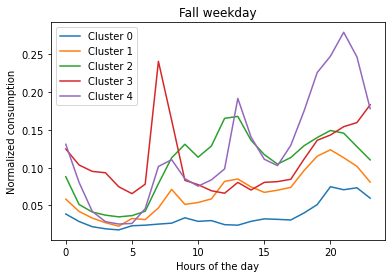

In [37]:
for x in lst_fa_week:
    clust_coef,center_df_fa_week = elbow_method(x,2,20,"Fall","weekday",clust_coef,center_df_fa_week)

In [38]:
#clustering centers added together for the different locations
center_df_fa_week.rename(index = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"})

0         1         2         3         4         5    \
all             0.036841  0.025178  0.020487  0.017957  0.017935  0.020586   
Krefeld         0.019394  0.012812  0.010677  0.010394  0.010629  0.011822   
Münster         0.043788  0.032270  0.030963  0.027700  0.029645  0.042528   
Schwerte        0.028912  0.020531  0.016309  0.014685  0.014932  0.015834   
Ulm             0.063684  0.036084  0.028445  0.025373  0.024604  0.024099   
Kaiserslautern  0.019061  0.013961  0.011533  0.010381  0.010841  0.014386   
Celle           0.048675  0.040610  0.033199  0.027102  0.026426  0.024168   
Haßfurt         0.038715  0.028825  0.021939  0.019165  0.017684  0.023168   

                     6         7         8         9    ...       110  \
all             0.027125  0.043357  0.046089  0.044738  ...  0.171385   
Krefeld         0.017325  0.041543  0.039657  0.042680  ...  0.217116   
Münster         0.062144  0.057427  0.054394  0.049306  ...  0.137922   
Schwerte        0.025804  0.033930  0.045836  0.041874  ...  0.113663   
Ulm             0.030380  0.051846  0.048854  0.049334  ...  0.290619   
Kaiserslautern  0.018471  0.027485  0.033836  0.040541  ...  0.144166   
Celle           0.030973  0.044733  0.043219  0.046533  ...  0.225375   
Haßfurt         0.023934  0.025369  0.026622  0.033739  ...  0.140507   

                     111       112       113       114       115       116  \
all             0.166047  0.174273  0.205696  0.268428  0.295999  0.297916   
Krefeld         0.197039  0.222958  0.208356  0.223920  0.269015  0.298390   
Münster         0.141702  0.163604  0.222521  0.331840  0.364867  0.371842   
Schwerte        0.123799  0.126139  0.138933  0.179128  0.216495  0.272378   
Ulm             0.266066  0.275658  0.290118  0.298141  0.266565  0.253664   
Kaiserslautern  0.143330  0.155008  0.159918  0.187422  0.203856  0.211547   
Celle           0.224293  0.242393  0.263881  0.388795  0.389328  0.385485   
Haßfurt         0.111132  0.102735  0.129473  0.174722  0.225806  0.247458   

                     117       118       119  
all             0.284741  0.237981  0.178519  
Krefeld         0.297186  0.257876  0.227124  
Münster         0.366450  0.291559  0.214079  
Schwerte        0.289956  0.265377  0.221917  
Ulm             0.255725  0.251620  0.172005  
Kaiserslautern  0.198209  0.172319  0.135812  
Celle           0.391696  0.301101  0.177709  
Haßfurt         0.279105  0.246536  0.178049  

[8 rows x 120 columns]

In [39]:
#calculate the correlation among these clustering results
center_df_fa_week_res = center_df_fa_week.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

In [40]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_fa_week = center_df_fa_week_res.values[np.triu_indices_from(center_df_fa_week_res.values,1)].mean()
coef_df_fa_week

0.7912045300702119

<AxesSubplot:>

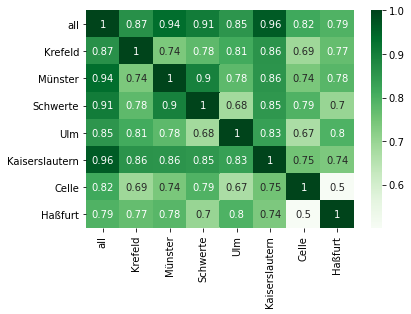

In [41]:
#create a heatmap with the correlation among the locations
sns.heatmap(center_df_fa_week_res,annot=True,cmap="Greens")

In [42]:
#cosin distance (optional different simmilarity measure)
#df_cosin = center_df_fa_week.rename(index = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"})
#cosin_dist = pairwise.cosine_similarity(df_cosin)

In [43]:
#center_df_fa_week.rename(index = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"})

In [44]:
#sns.heatmap(cosin_dist,annot=True,cmap="Greens")

### Fall weekend 

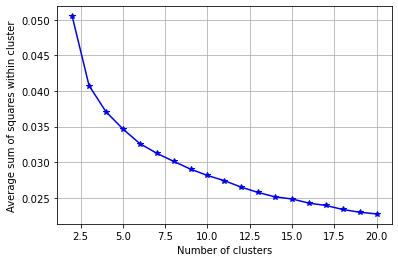

Cluster 0 has 120 clustering members
Cluster 1 has 172 clustering members
Cluster 2 has 92 clustering members
Cluster 3 has 91 clustering members
Cluster 4 has 37 clustering members
Int64Index([  13,  147,  157,  178,  216,  220,  469,  480,  492,  547,  558,
             602,  614,  627,  637,  643,  648,  649,  655,  684,  691,  692,
             696,  701, 1007, 1013, 1021, 1022, 1094, 1306, 1313, 1314, 1315,
            1317, 1319, 1325, 1358],
           dtype='int64', name='Fall_ge1')


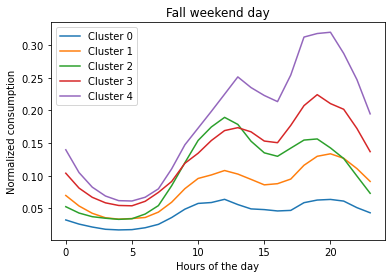

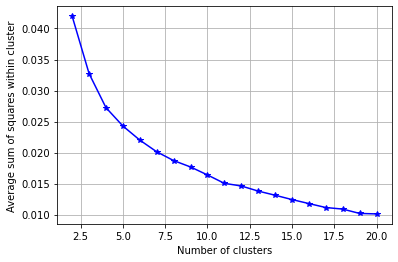

Cluster 0 has 16 clustering members
Cluster 1 has 40 clustering members
Cluster 2 has 17 clustering members
Cluster 3 has 8 clustering members
Cluster 4 has 6 clustering members
Int64Index([13, 68, 1007, 1013, 1021, 1022], dtype='int64', name='Fall_ge1')


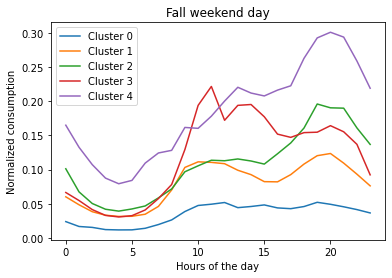

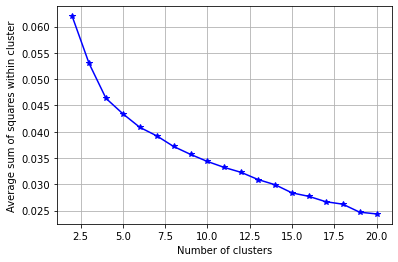

Cluster 0 has 34 clustering members
Cluster 1 has 27 clustering members
Cluster 2 has 18 clustering members
Cluster 3 has 32 clustering members
Cluster 4 has 6 clustering members
Int64Index([558, 602, 655, 692, 1317, 1325], dtype='int64', name='Fall_ge1')


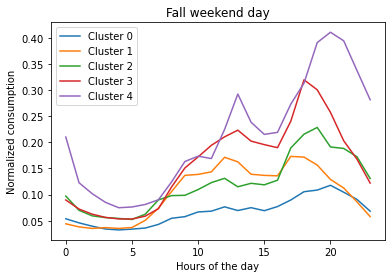

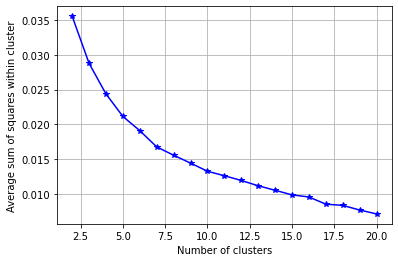

Cluster 0 has 16 clustering members
Cluster 1 has 10 clustering members
Cluster 2 has 12 clustering members
Cluster 3 has 13 clustering members
Cluster 4 has 2 clustering members
Int64Index([104, 147], dtype='int64', name='Fall_ge1')


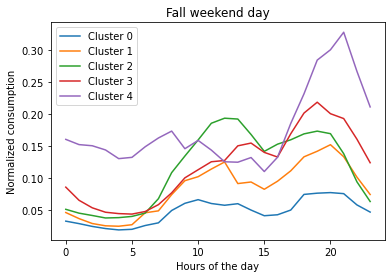

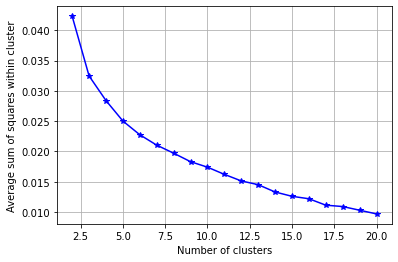

Cluster 0 has 15 clustering members
Cluster 1 has 24 clustering members
Cluster 2 has 18 clustering members
Cluster 3 has 4 clustering members
Cluster 4 has 1 clustering members
Int64Index([1103], dtype='int64', name='Fall_ge1')


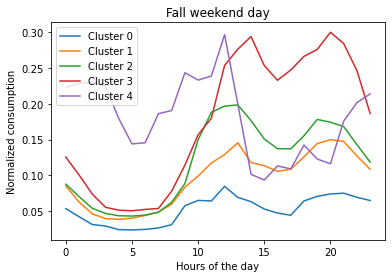

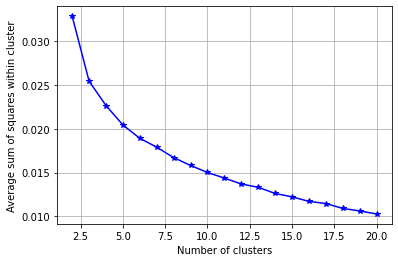

Cluster 0 has 28 clustering members
Cluster 1 has 15 clustering members
Cluster 2 has 23 clustering members
Cluster 3 has 18 clustering members
Cluster 4 has 16 clustering members
Int64Index([ 322,  325,  339,  349,  376,  381, 1171, 1172, 1173, 1176, 1181,
            1189, 1191, 1193, 1202, 1204],
           dtype='int64', name='Fall_ge1')


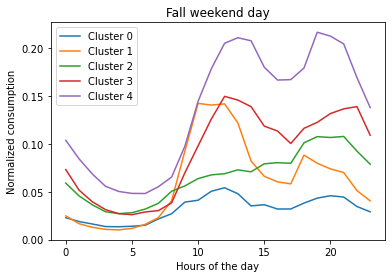

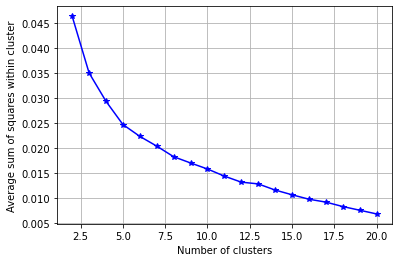

Cluster 0 has 10 clustering members
Cluster 1 has 24 clustering members
Cluster 2 has 1 clustering members
Cluster 3 has 10 clustering members
Cluster 4 has 3 clustering members
Int64Index([469, 480, 492], dtype='int64', name='Fall_ge1')


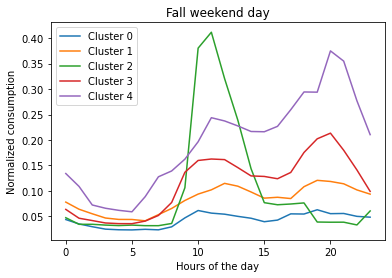

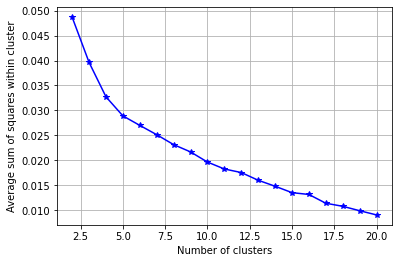

Cluster 0 has 15 clustering members
Cluster 1 has 15 clustering members
Cluster 2 has 7 clustering members
Cluster 3 has 6 clustering members
Cluster 4 has 2 clustering members
Int64Index([244, 269], dtype='int64', name='Fall_ge1')


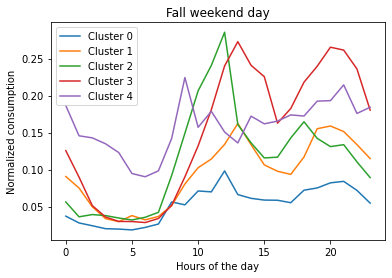

In [45]:
#initiate df for the clustering centers
center_df_fa_wknd =pd.DataFrame()

#list for for-loop with all the locations
lst_fa_wknd = [df_fa_wknd,df_fa_wknd_kre,df_fa_wknd_mue,df_fa_wknd_schw,df_fa_wknd_ulm,df_fa_wknd_kai,df_fa_wknd_cel,df_fa_wknd_hass]

#main clustering function for all the locations
for x in lst_fa_wknd:
    clust_coef,center_df_fa_wknd = elbow_method(x,2,20,"Fall","weekend day",clust_coef,center_df_fa_wknd)

In [46]:
center_df_fa_wknd_res = center_df_fa_wknd.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

In [47]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_fa_wknd = center_df_fa_wknd_res.values[np.triu_indices_from(center_df_fa_wknd_res.values,1)].mean()
coef_df_fa_wknd

0.7978204201716211

<AxesSubplot:>

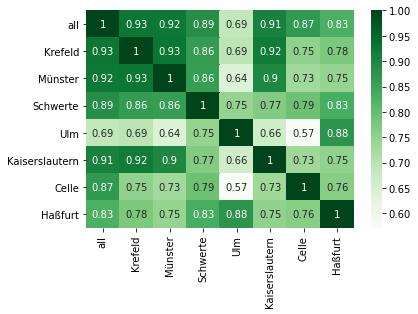

In [48]:
sns.heatmap(center_df_fa_wknd_res,annot=True,cmap="Greens")

# Winter

### Winter weekdays

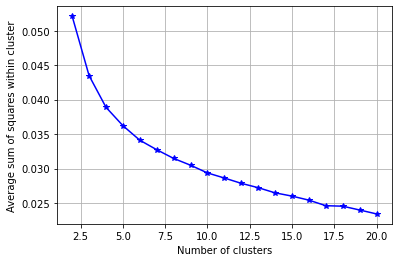

Cluster 0 has 107 clustering members
Cluster 1 has 185 clustering members
Cluster 2 has 107 clustering members
Cluster 3 has 68 clustering members
Cluster 4 has 45 clustering members
Int64Index([  15,   21,   25,   45,  104,  147,  178,  252,  261,  375,  469,
             480,  487,  491,  547,  556,  558,  563,  581,  602,  614,  627,
             637,  643,  646,  684,  692,  701, 1007, 1013, 1016, 1073, 1172,
            1189, 1202, 1310, 1314, 1318, 1319, 1325, 1330, 1340, 1354, 1358,
            1359],
           dtype='int64', name='Fall_ge1')


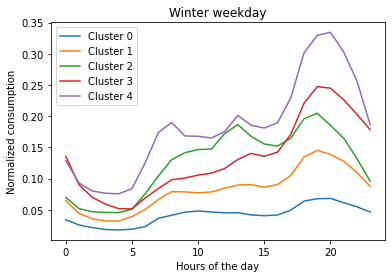

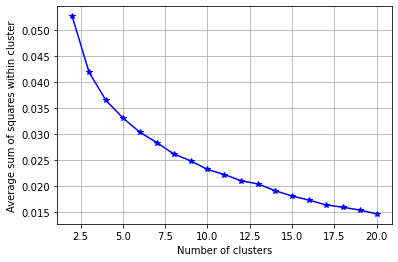

Cluster 0 has 17 clustering members
Cluster 1 has 37 clustering members
Cluster 2 has 18 clustering members
Cluster 3 has 12 clustering members
Cluster 4 has 3 clustering members
Int64Index([21, 45, 1013], dtype='int64', name='Fall_ge1')


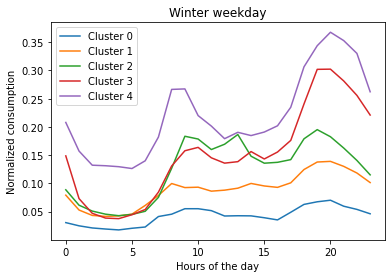

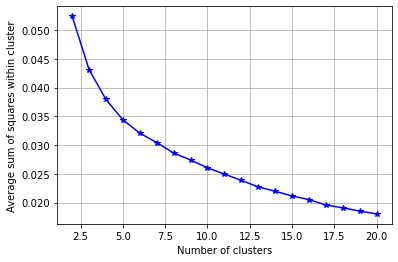

Cluster 0 has 31 clustering members
Cluster 1 has 33 clustering members
Cluster 2 has 25 clustering members
Cluster 3 has 9 clustering members
Cluster 4 has 19 clustering members
Int64Index([ 556,  558,  581,  602,  614,  627,  637,  643,  646,  684,  692,
             701, 1310, 1314, 1318, 1319, 1340, 1358, 1359],
           dtype='int64', name='Fall_ge1')


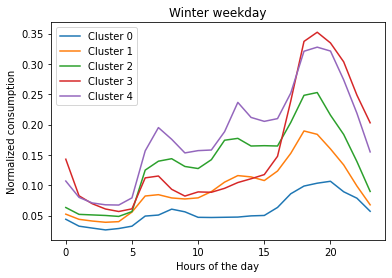

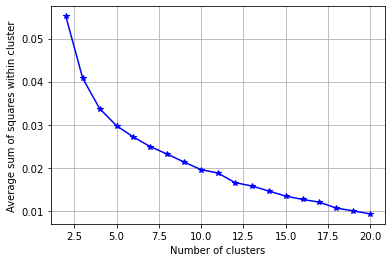

Cluster 0 has 12 clustering members
Cluster 1 has 18 clustering members
Cluster 2 has 11 clustering members
Cluster 3 has 10 clustering members
Cluster 4 has 2 clustering members
Int64Index([104, 147], dtype='int64', name='Fall_ge1')


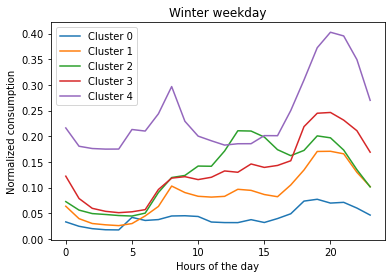

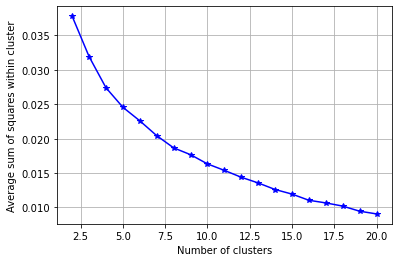

Cluster 0 has 12 clustering members
Cluster 1 has 21 clustering members
Cluster 2 has 12 clustering members
Cluster 3 has 15 clustering members
Cluster 4 has 2 clustering members
Int64Index([157, 178], dtype='int64', name='Fall_ge1')


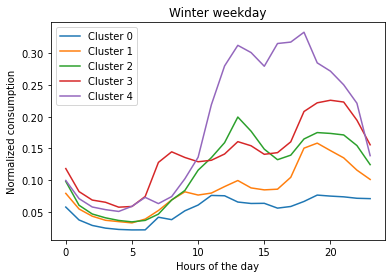

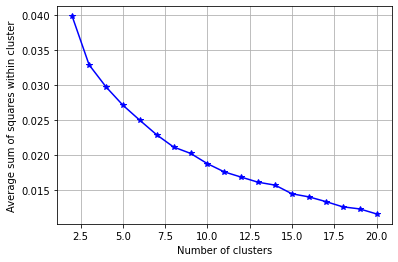

Cluster 0 has 39 clustering members
Cluster 1 has 34 clustering members
Cluster 2 has 13 clustering members
Cluster 3 has 13 clustering members
Cluster 4 has 1 clustering members
Int64Index([375], dtype='int64', name='Fall_ge1')


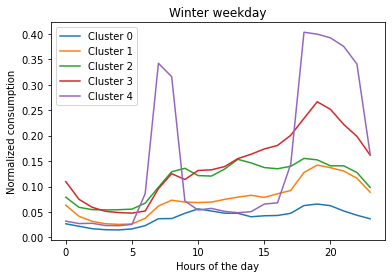

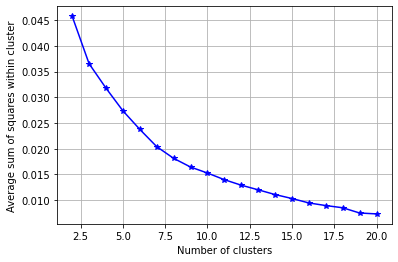

Cluster 0 has 9 clustering members
Cluster 1 has 16 clustering members
Cluster 2 has 12 clustering members
Cluster 3 has 9 clustering members
Cluster 4 has 2 clustering members
Int64Index([469, 480], dtype='int64', name='Fall_ge1')


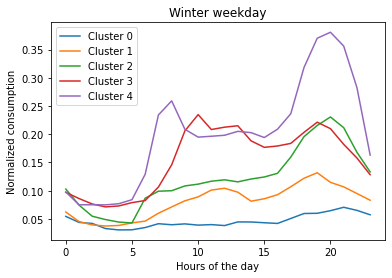

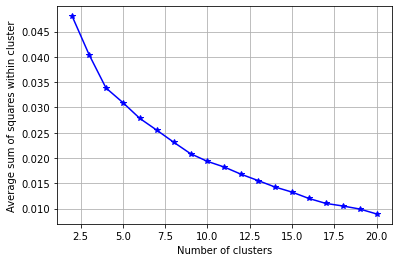

Cluster 0 has 15 clustering members
Cluster 1 has 8 clustering members
Cluster 2 has 9 clustering members
Cluster 3 has 8 clustering members
Cluster 4 has 5 clustering members
Int64Index([220, 244, 246, 252, 261], dtype='int64', name='Fall_ge1')


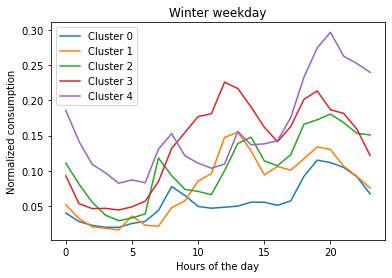

In [49]:
#initiate df for the clustering centers
center_df_wi_week =pd.DataFrame()

#list for for-loop with all the locations
lst_wi_week = [df_wi_week,df_wi_week_kre,df_wi_week_mue,df_wi_week_schw,df_wi_week_ulm,df_wi_week_kai,df_wi_week_cel,df_wi_week_hass]

#main clustering function for all the locations
for x in lst_wi_week:
    clust_coef,center_df_wi_week = elbow_method(x,2,20,"Winter","weekday",clust_coef,center_df_wi_week)

In [50]:
center_df_wi_week_res = center_df_wi_week.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

<AxesSubplot:>

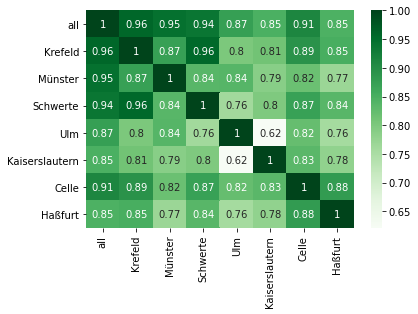

In [51]:
sns.heatmap(center_df_wi_week_res,annot=True,cmap="Greens")

In [52]:
center_df_wi_week

0         1         2         3         4         5         6    \
0  0.034064  0.025689  0.021479  0.018426  0.017752  0.018785  0.023133   
1  0.030589  0.024932  0.021148  0.019246  0.017668  0.020580  0.022802   
2  0.043921  0.032534  0.029402  0.026374  0.028681  0.032537  0.049198   
3  0.033124  0.024548  0.019910  0.017782  0.017472  0.041901  0.035929   
4  0.057307  0.036921  0.028282  0.024041  0.021956  0.021208  0.021299   
5  0.026780  0.021888  0.017095  0.015079  0.014725  0.016649  0.023148   
6  0.054423  0.043745  0.041914  0.032830  0.030435  0.030650  0.034645   
7  0.040169  0.028055  0.022694  0.019994  0.019855  0.025410  0.028336   

        7         8         9    ...       110       111       112       113  \
0  0.036508  0.041211  0.046234  ...  0.185567  0.180981  0.189424  0.229186   
1  0.041359  0.045508  0.055198  ...  0.184705  0.190934  0.202013  0.234818   
2  0.050876  0.060598  0.056198  ...  0.211793  0.205311  0.209830  0.251930   
3  0.037615  0.044626  0.045094  ...  0.185513  0.201234  0.201103  0.250144   
4  0.041272  0.037424  0.051406  ...  0.301456  0.279823  0.315760  0.317989   
5  0.036743  0.037060  0.047378  ...  0.050541  0.065483  0.068025  0.144189   
6  0.041437  0.039607  0.041119  ...  0.202867  0.194224  0.208978  0.236334   
7  0.043798  0.077777  0.065126  ...  0.136975  0.138297  0.142856  0.175603   

        114       115       116       117       118       119  
0  0.301244  0.329364  0.334485  0.302778  0.256569  0.186166  
1  0.306390  0.343780  0.367630  0.352887  0.330129  0.262228  
2  0.320889  0.327620  0.321217  0.273657  0.218631  0.154956  
3  0.309718  0.372506  0.402719  0.395508  0.349355  0.269999  
4  0.333554  0.285177  0.272066  0.250492  0.221376  0.138545  
5  0.403236  0.399545  0.392246  0.375381  0.340788  0.163648  
6  0.318328  0.370250  0.380863  0.356384  0.282826  0.163073  
7  0.232983  0.274353  0.296602  0.262643  0.252258  0.239659  

[8 rows x 120 columns]

In [53]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_wi_week = center_df_wi_week_res.values[np.triu_indices_from(center_df_wi_week_res.values,1)].mean()
coef_df_wi_week

0.8406125477136358

### Winter weekend days

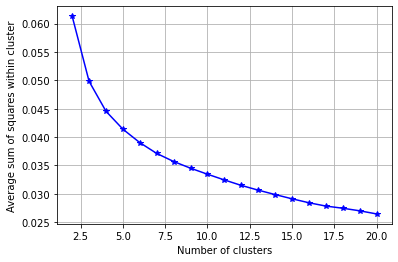

Cluster 0 has 120 clustering members
Cluster 1 has 176 clustering members
Cluster 2 has 96 clustering members
Cluster 3 has 78 clustering members
Cluster 4 has 42 clustering members
Int64Index([  21,   45,   68,  104,  147,  178,  216,  261,  375,  469,  480,
             558,  602,  614,  627,  631,  637,  643,  646,  647,  649,  655,
             684,  692,  701, 1007, 1013, 1021, 1073, 1172, 1189, 1202, 1306,
            1307, 1310, 1314, 1317, 1319, 1325, 1340, 1358, 1359],
           dtype='int64', name='Fall_ge1')


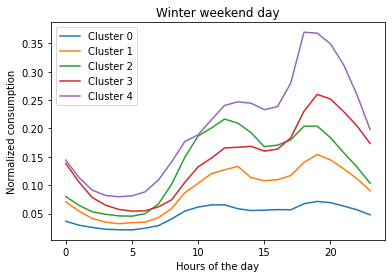

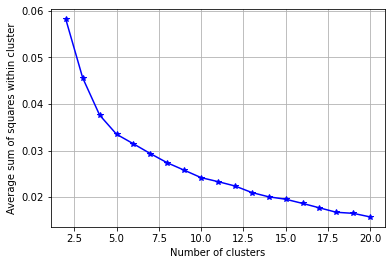

Cluster 0 has 15 clustering members
Cluster 1 has 37 clustering members
Cluster 2 has 10 clustering members
Cluster 3 has 19 clustering members
Cluster 4 has 6 clustering members
Int64Index([21, 45, 68, 1007, 1013, 1021], dtype='int64', name='Fall_ge1')


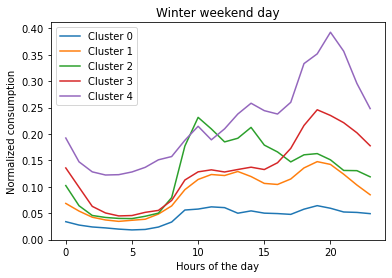

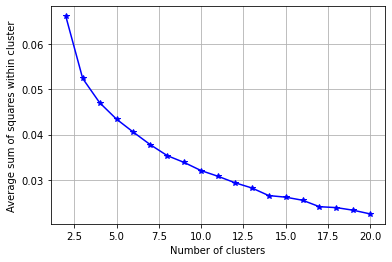

Cluster 0 has 19 clustering members
Cluster 1 has 32 clustering members
Cluster 2 has 26 clustering members
Cluster 3 has 28 clustering members
Cluster 4 has 12 clustering members
Int64Index([558, 627, 637, 643, 646, 655, 692, 1310, 1319, 1325, 1354, 1358], dtype='int64', name='Fall_ge1')


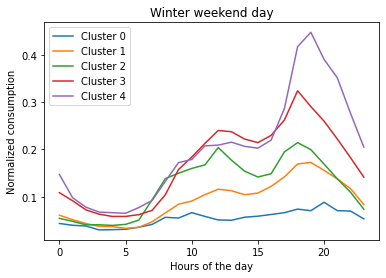

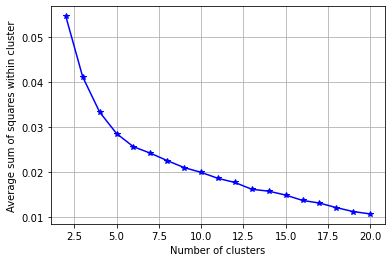

Cluster 0 has 14 clustering members
Cluster 1 has 15 clustering members
Cluster 2 has 11 clustering members
Cluster 3 has 11 clustering members
Cluster 4 has 2 clustering members
Int64Index([104, 147], dtype='int64', name='Fall_ge1')


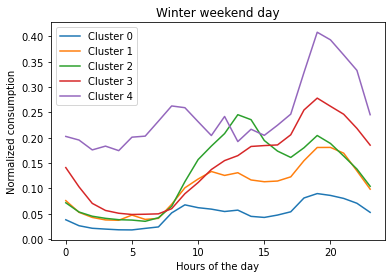

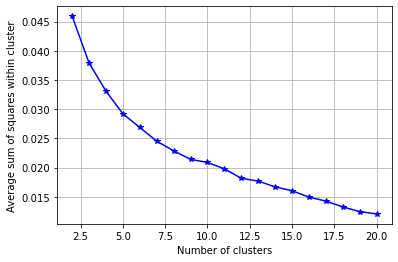

Cluster 0 has 15 clustering members
Cluster 1 has 23 clustering members
Cluster 2 has 20 clustering members
Cluster 3 has 2 clustering members
Cluster 4 has 2 clustering members
Int64Index([155, 1103], dtype='int64', name='Fall_ge1')


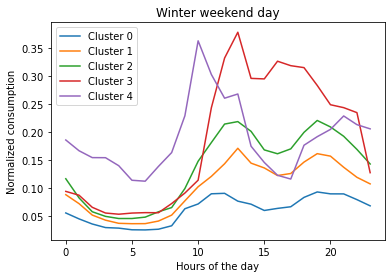

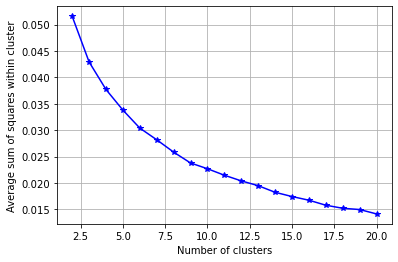

Cluster 0 has 27 clustering members
Cluster 1 has 32 clustering members
Cluster 2 has 16 clustering members
Cluster 3 has 21 clustering members
Cluster 4 has 4 clustering members
Int64Index([375, 1172, 1189, 1202], dtype='int64', name='Fall_ge1')


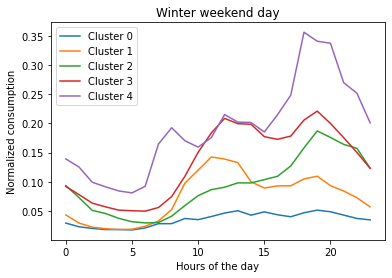

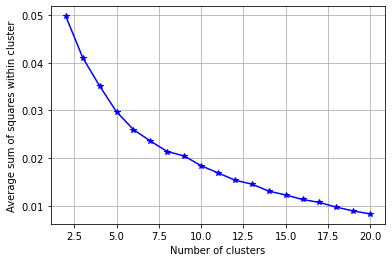

Cluster 0 has 8 clustering members
Cluster 1 has 20 clustering members
Cluster 2 has 9 clustering members
Cluster 3 has 9 clustering members
Cluster 4 has 2 clustering members
Int64Index([469, 480], dtype='int64', name='Fall_ge1')


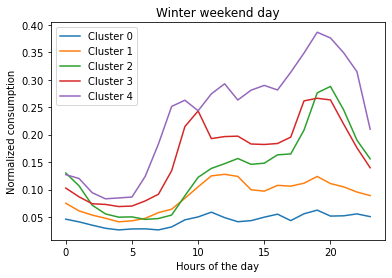

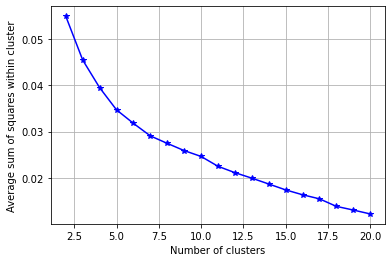

Cluster 0 has 15 clustering members
Cluster 1 has 11 clustering members
Cluster 2 has 8 clustering members
Cluster 3 has 5 clustering members
Cluster 4 has 6 clustering members
Int64Index([216, 220, 221, 258, 261, 262], dtype='int64', name='Fall_ge1')


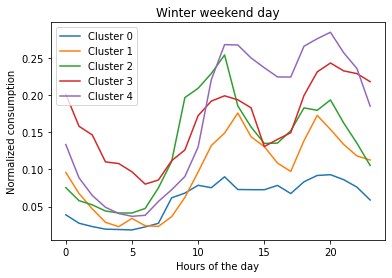

In [54]:
#initiate df for the clustering centers
center_df_wi_wknd =pd.DataFrame()

#list for for-loop with all the locations
lst_wi_wknd = [df_wi_wknd,df_wi_wknd_kre,df_wi_wknd_mue,df_wi_wknd_schw,df_wi_wknd_ulm,df_wi_wknd_kai,df_wi_wknd_cel,df_wi_wknd_hass]

#main clustering function for all the locations
for x in lst_wi_wknd:
    clust_coef,center_df_wi_wknd = elbow_method(x,2,20,"Winter","weekend day",clust_coef,center_df_wi_wknd)

In [55]:
center_df_wi_wknd_res = center_df_wi_wknd.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Hassfurt"}).corr()

<AxesSubplot:>

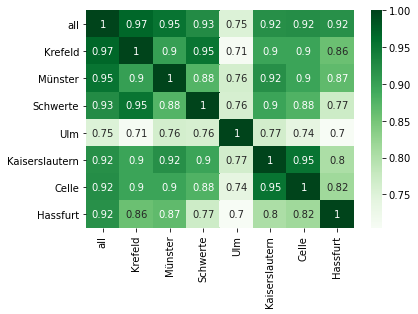

In [56]:
sns.heatmap(center_df_wi_wknd_res,annot=True,cmap="Greens")

In [57]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_wi_wknd = center_df_wi_wknd_res.values[np.triu_indices_from(center_df_wi_wknd_res.values,1)].mean()
coef_df_wi_wknd

0.8569188601164585

# Spring

### Spring weekdays

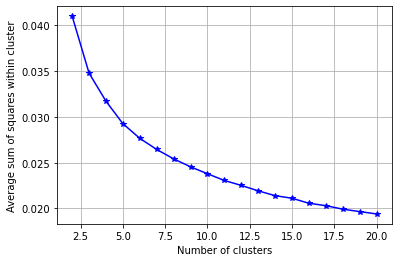

Cluster 0 has 105 clustering members
Cluster 1 has 226 clustering members
Cluster 2 has 122 clustering members
Cluster 3 has 76 clustering members
Cluster 4 has 33 clustering members
Int64Index([  21,  178,  228,  261,  269,  330,  469,  480,  558,  581,  614,
             637,  643,  647,  684,  692,  701, 1007, 1013, 1073, 1111, 1124,
            1133, 1161, 1189, 1193, 1314, 1317, 1318, 1319, 1330, 1358, 1359],
           dtype='int64', name='Fall_ge1')


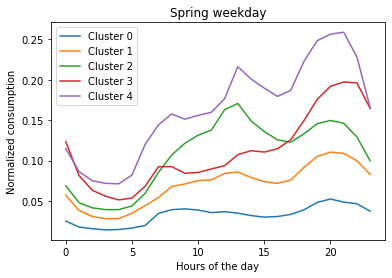

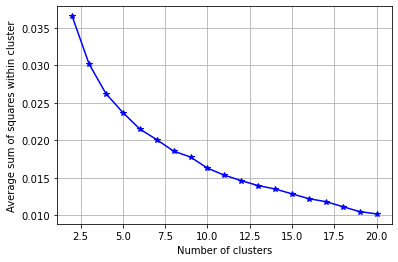

Cluster 0 has 12 clustering members
Cluster 1 has 34 clustering members
Cluster 2 has 30 clustering members
Cluster 3 has 3 clustering members
Cluster 4 has 8 clustering members
Int64Index([15, 21, 42, 55, 1007, 1013, 1021, 1022], dtype='int64', name='Fall_ge1')


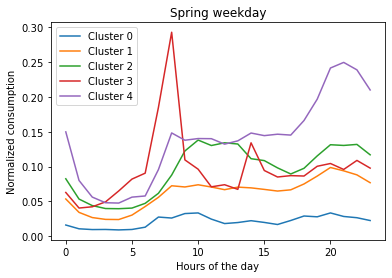

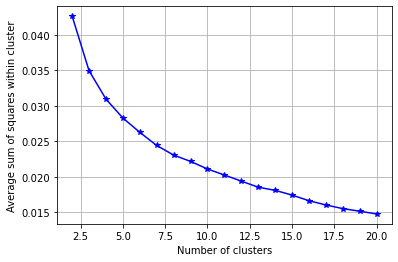

Cluster 0 has 27 clustering members
Cluster 1 has 36 clustering members
Cluster 2 has 23 clustering members
Cluster 3 has 20 clustering members
Cluster 4 has 11 clustering members
Int64Index([558, 581, 614, 637, 643, 655, 692, 1317, 1319, 1330, 1354], dtype='int64', name='Fall_ge1')


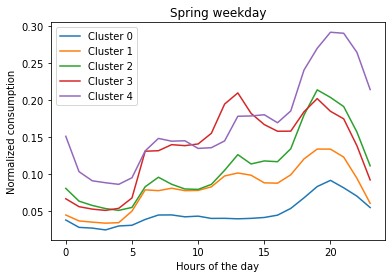

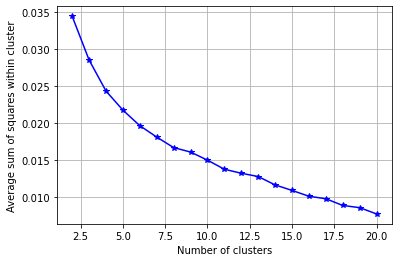

Cluster 0 has 8 clustering members
Cluster 1 has 24 clustering members
Cluster 2 has 9 clustering members
Cluster 3 has 12 clustering members
Cluster 4 has 2 clustering members
Int64Index([104, 147], dtype='int64', name='Fall_ge1')


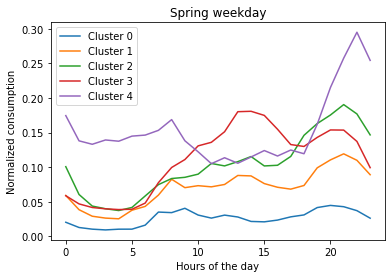

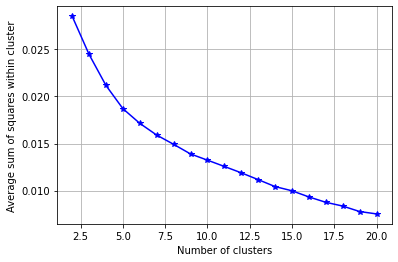

Cluster 0 has 13 clustering members
Cluster 1 has 19 clustering members
Cluster 2 has 13 clustering members
Cluster 3 has 16 clustering members
Cluster 4 has 1 clustering members
Int64Index([178], dtype='int64', name='Fall_ge1')


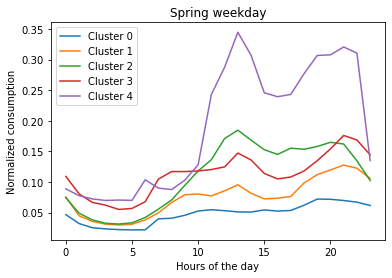

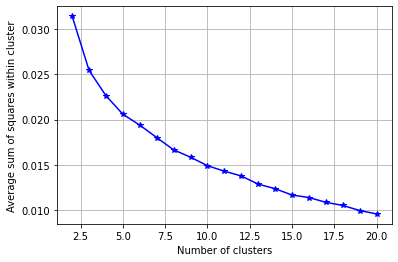

Cluster 0 has 16 clustering members
Cluster 1 has 33 clustering members
Cluster 2 has 28 clustering members
Cluster 3 has 9 clustering members
Cluster 4 has 14 clustering members
Int64Index([285, 319, 325, 330, 368, 372, 376, 1171, 1176, 1181, 1189, 1191,
            1193, 1202],
           dtype='int64', name='Fall_ge1')


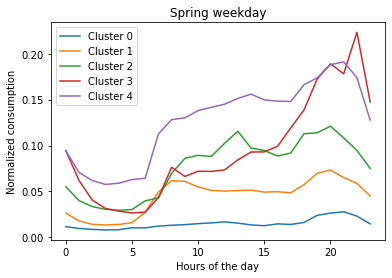

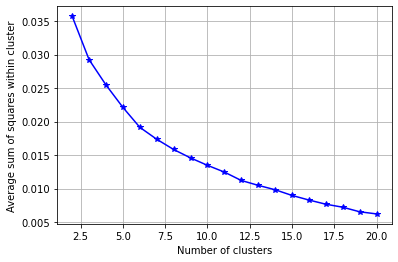

Cluster 0 has 5 clustering members
Cluster 1 has 22 clustering members
Cluster 2 has 20 clustering members
Cluster 3 has 1 clustering members
Cluster 4 has 1 clustering members
Int64Index([480], dtype='int64', name='Fall_ge1')


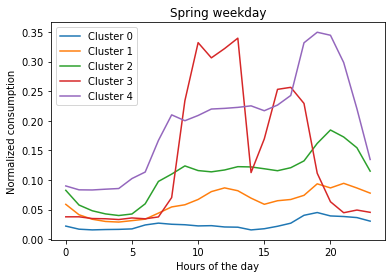

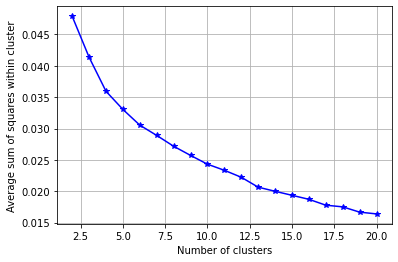

Cluster 0 has 28 clustering members
Cluster 1 has 25 clustering members
Cluster 2 has 25 clustering members
Cluster 3 has 10 clustering members
Cluster 4 has 4 clustering members
Int64Index([261, 1124, 1133, 1161], dtype='int64', name='Fall_ge1')


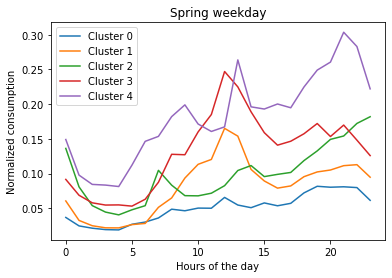

In [58]:
#initiate df for the clustering centers
center_df_sp_week =pd.DataFrame()

#list for for-loop with all the locations
lst_sp_week = [df_sp_week,df_sp_week_kre,df_sp_week_mue,df_sp_week_schw,df_sp_week_ulm,df_sp_week_kai,df_sp_week_cel,df_sp_week_hass]

#main clustering function for all the locations
for x in lst_sp_week:
    clust_coef,center_df_sp_week = elbow_method(x,2,20,"Spring","weekday",clust_coef,center_df_sp_week)

In [59]:
center_df_sp_week_res = center_df_sp_week.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

In [60]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_fa_week = center_df_fa_week_res.mean().mean()

<AxesSubplot:>

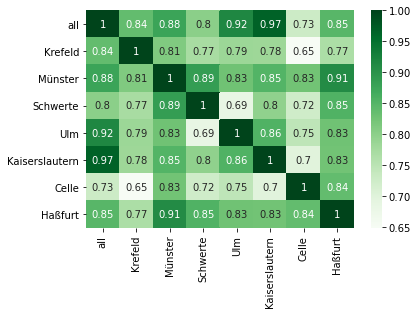

In [61]:
sns.heatmap(center_df_sp_week_res,annot=True,cmap="Greens")

In [62]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_sp_week = center_df_sp_week_res.values[np.triu_indices_from(center_df_sp_week_res.values,1)].mean()
coef_df_sp_week

0.8111330563896122

### Spring weekend days

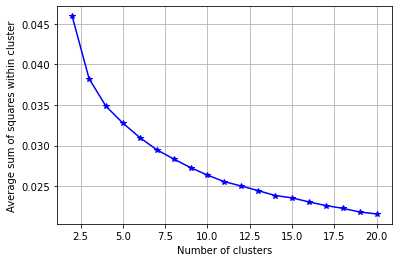

Cluster 0 has 95 clustering members
Cluster 1 has 211 clustering members
Cluster 2 has 97 clustering members
Cluster 3 has 94 clustering members
Cluster 4 has 65 clustering members
Int64Index([   5,   21,   68,  124,  157,  162,  178,  210,  216,  219,  258,
             261,  262,  269,  285,  325,  330,  368,  372,  469,  472,  480,
             488,  492,  547,  552,  558,  581,  602,  614,  627,  637,  643,
             646,  647,  648,  655,  669,  684,  692,  701, 1007, 1013, 1021,
            1068, 1073, 1078, 1111, 1124, 1133, 1143, 1161, 1193, 1306, 1310,
            1314, 1315, 1317, 1318, 1319, 1320, 1330, 1340, 1358, 1359],
           dtype='int64', name='Fall_ge1')


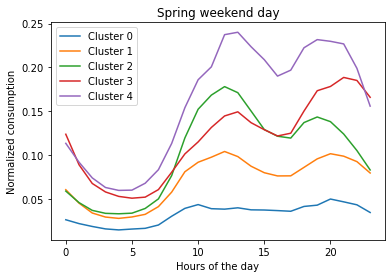

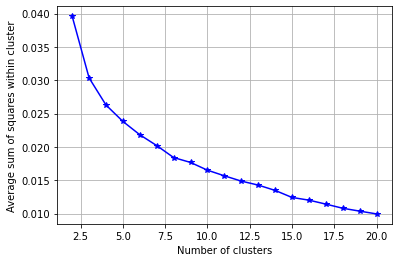

Cluster 0 has 9 clustering members
Cluster 1 has 26 clustering members
Cluster 2 has 31 clustering members
Cluster 3 has 15 clustering members
Cluster 4 has 6 clustering members
Int64Index([5, 21, 68, 1007, 1013, 1021], dtype='int64', name='Fall_ge1')


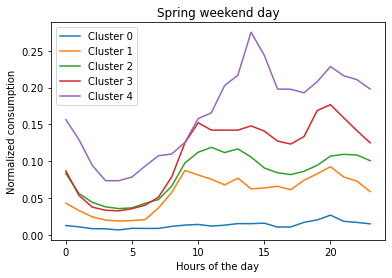

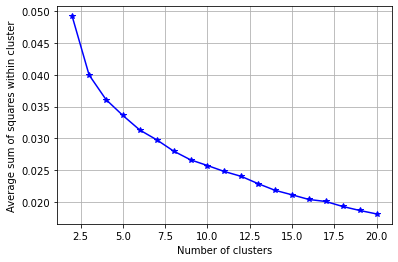

Cluster 0 has 36 clustering members
Cluster 1 has 35 clustering members
Cluster 2 has 18 clustering members
Cluster 3 has 19 clustering members
Cluster 4 has 9 clustering members
Int64Index([558, 581, 614, 637, 655, 1317, 1325, 1330, 1354], dtype='int64', name='Fall_ge1')


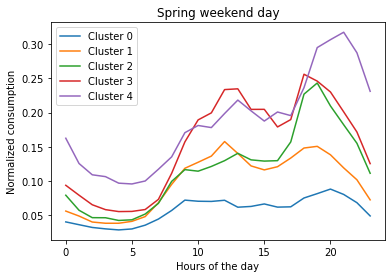

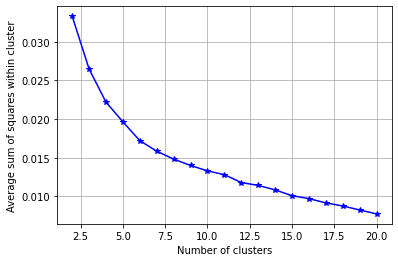

Cluster 0 has 21 clustering members
Cluster 1 has 15 clustering members
Cluster 2 has 8 clustering members
Cluster 3 has 9 clustering members
Cluster 4 has 2 clustering members
Int64Index([104, 147], dtype='int64', name='Fall_ge1')


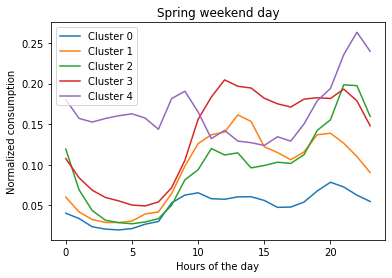

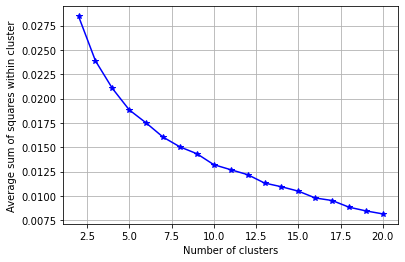

Cluster 0 has 13 clustering members
Cluster 1 has 22 clustering members
Cluster 2 has 16 clustering members
Cluster 3 has 10 clustering members
Cluster 4 has 1 clustering members
Int64Index([178], dtype='int64', name='Fall_ge1')


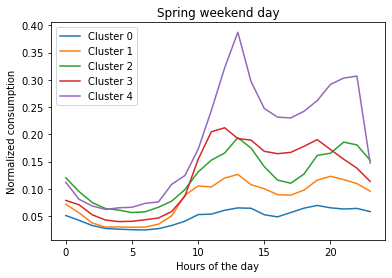

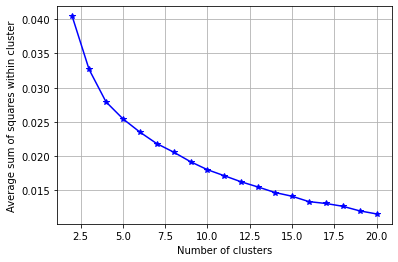

Cluster 0 has 19 clustering members
Cluster 1 has 41 clustering members
Cluster 2 has 15 clustering members
Cluster 3 has 18 clustering members
Cluster 4 has 7 clustering members
Int64Index([285, 325, 330, 368, 372, 1172, 1193], dtype='int64', name='Fall_ge1')


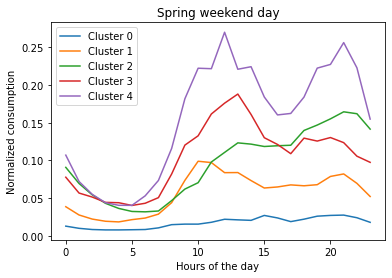

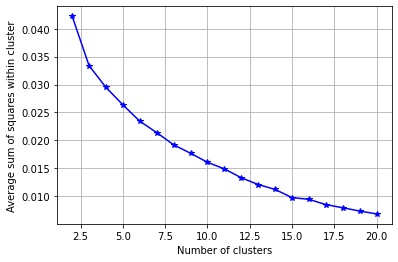

Cluster 0 has 4 clustering members
Cluster 1 has 25 clustering members
Cluster 2 has 13 clustering members
Cluster 3 has 6 clustering members
Cluster 4 has 1 clustering members
Int64Index([480], dtype='int64', name='Fall_ge1')


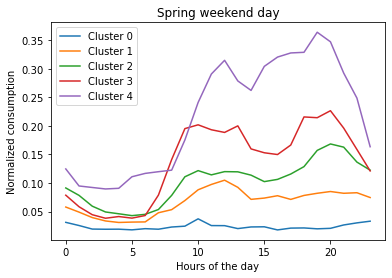

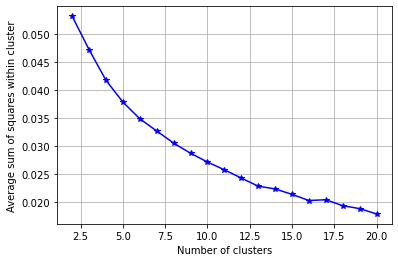

Cluster 0 has 26 clustering members
Cluster 1 has 26 clustering members
Cluster 2 has 24 clustering members
Cluster 3 has 15 clustering members
Cluster 4 has 1 clustering members
Int64Index([1111], dtype='int64', name='Fall_ge1')


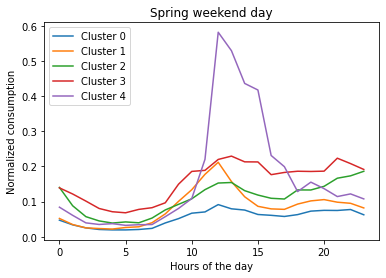

In [63]:
#initiate df for the clustering centers
center_df_sp_wknd =pd.DataFrame()

#list for for-loop with all the locations
lst_sp_wknd = [df_sp_wknd,df_sp_wknd_kre,df_sp_wknd_mue,df_sp_wknd_schw,df_sp_wknd_ulm,df_sp_wknd_kai,df_sp_wknd_cel,df_sp_wknd_hass]

#main clustering function for all the locations
for x in lst_sp_wknd:
    clust_coef,center_df_sp_wknd = elbow_method(x,2,20,"Spring","weekend day",clust_coef,center_df_sp_wknd)

In [64]:
center_df_sp_wknd_res = center_df_sp_wknd.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

<AxesSubplot:>

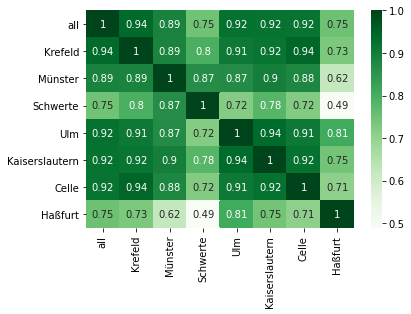

In [65]:
sns.heatmap(center_df_sp_wknd_res,annot=True,cmap="Greens")

In [66]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_sp_wknd = center_df_sp_wknd_res.values[np.triu_indices_from(center_df_sp_wknd_res.values,1)].mean()
coef_df_sp_wknd

0.827841784460124

# Summer

### Summer weekdays

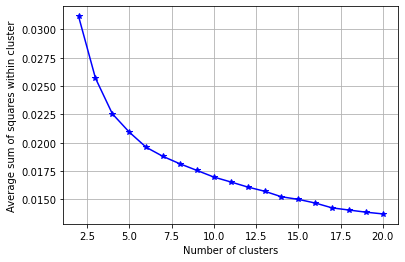

Cluster 0 has 101 clustering members
Cluster 1 has 228 clustering members
Cluster 2 has 98 clustering members
Cluster 3 has 101 clustering members
Cluster 4 has 33 clustering members
Int64Index([  13,   21,  155,  178,  228,  269,  480,  486,  558,  614,  637,
             643,  647,  648,  684,  692, 1007, 1013, 1101, 1103, 1111, 1114,
            1126, 1133, 1161, 1314, 1317, 1319, 1329, 1330, 1354, 1358, 1359],
           dtype='int64', name='Fall_ge1')


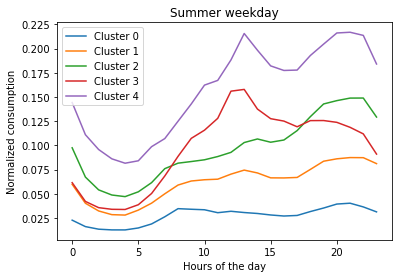

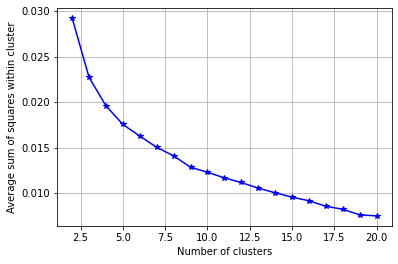

Cluster 0 has 21 clustering members
Cluster 1 has 29 clustering members
Cluster 2 has 19 clustering members
Cluster 3 has 14 clustering members
Cluster 4 has 4 clustering members
Int64Index([6, 13, 21, 1007], dtype='int64', name='Fall_ge1')


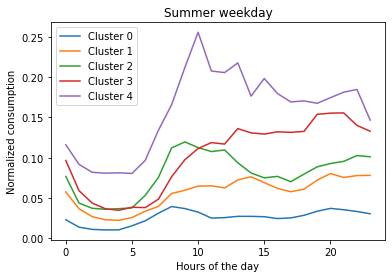

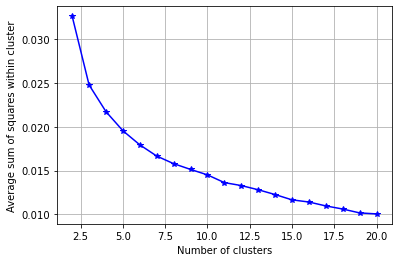

Cluster 0 has 16 clustering members
Cluster 1 has 41 clustering members
Cluster 2 has 27 clustering members
Cluster 3 has 16 clustering members
Cluster 4 has 16 clustering members
Int64Index([ 558,  614,  637,  643,  647,  648,  684,  692, 1314, 1317, 1319,
            1329, 1330, 1354, 1358, 1359],
           dtype='int64', name='Fall_ge1')


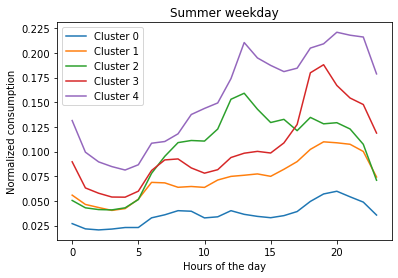

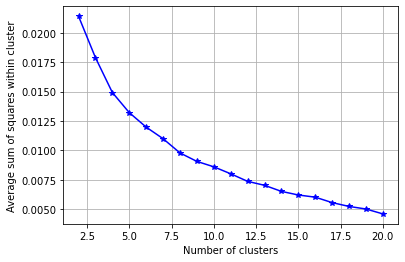

Cluster 0 has 10 clustering members
Cluster 1 has 20 clustering members
Cluster 2 has 13 clustering members
Cluster 3 has 8 clustering members
Cluster 4 has 4 clustering members
Int64Index([104, 122, 133, 147], dtype='int64', name='Fall_ge1')


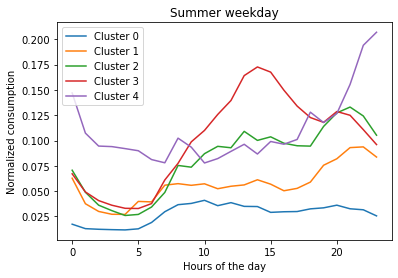

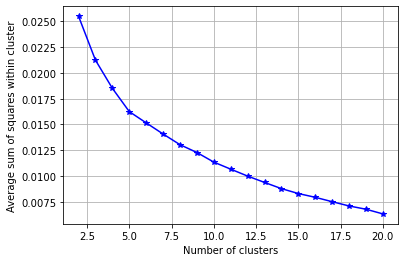

Cluster 0 has 15 clustering members
Cluster 1 has 22 clustering members
Cluster 2 has 13 clustering members
Cluster 3 has 10 clustering members
Cluster 4 has 2 clustering members
Int64Index([178, 1101], dtype='int64', name='Fall_ge1')


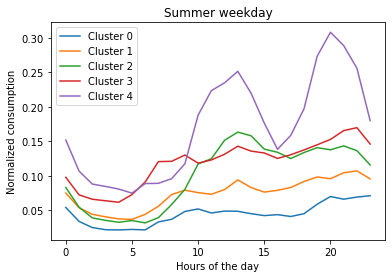

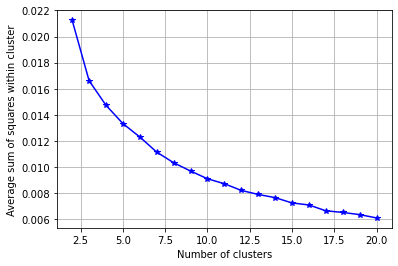

Cluster 0 has 10 clustering members
Cluster 1 has 27 clustering members
Cluster 2 has 33 clustering members
Cluster 3 has 16 clustering members
Cluster 4 has 14 clustering members
Int64Index([319, 325, 330, 368, 372, 375, 376, 1171, 1172, 1176, 1181, 1190,
            1193, 1204],
           dtype='int64', name='Fall_ge1')


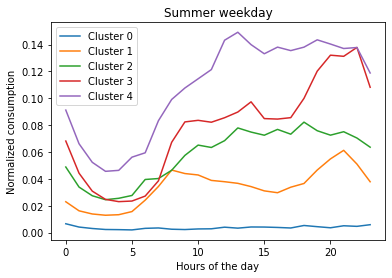

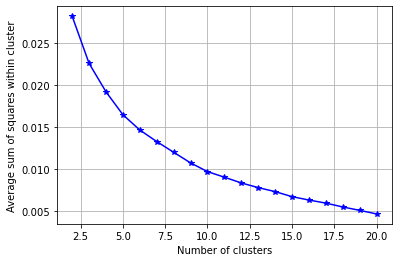

Cluster 0 has 4 clustering members
Cluster 1 has 22 clustering members
Cluster 2 has 17 clustering members
Cluster 3 has 1 clustering members
Cluster 4 has 5 clustering members
Int64Index([469, 480, 486, 492, 518], dtype='int64', name='Fall_ge1')


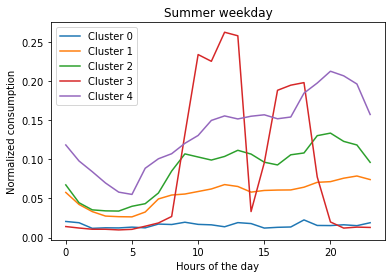

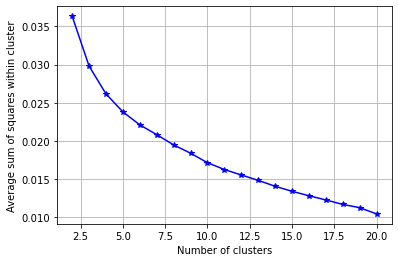

Cluster 0 has 33 clustering members
Cluster 1 has 31 clustering members
Cluster 2 has 12 clustering members
Cluster 3 has 11 clustering members
Cluster 4 has 5 clustering members
Int64Index([228, 1114, 1126, 1133, 1161], dtype='int64', name='Fall_ge1')


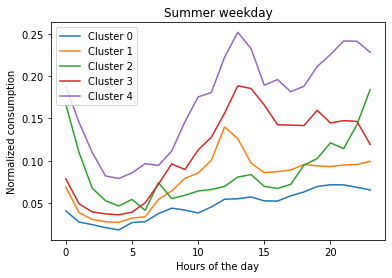

In [67]:
#initiate df for the clustering centers
center_df_su_week =pd.DataFrame()

#list for for-loop with all the locations
lst_su_week = [df_su_week,df_su_week_kre,df_su_week_mue,df_su_week_schw,df_su_week_ulm,df_su_week_kai,df_su_week_cel,df_su_week_hass]

#main clustering function for all the locations
for x in lst_su_week:
    clust_coef,center_df_su_week = elbow_method(x,2,20,"Summer","weekday",clust_coef,center_df_su_week)

In [68]:
center_df_su_week_res = center_df_su_week.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

<AxesSubplot:>

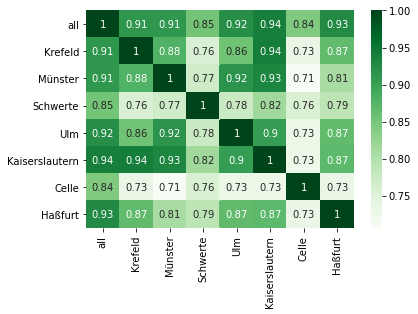

In [69]:
sns.heatmap(center_df_su_week_res,annot=True,cmap="Greens")

In [70]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_su_week = center_df_su_week_res.values[np.triu_indices_from(center_df_su_week_res.values,1)].mean()
coef_df_su_week

0.8380899256142877

### Summer weekend days

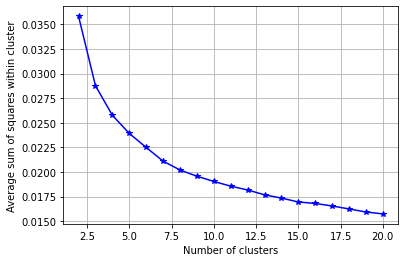

Cluster 0 has 66 clustering members
Cluster 1 has 162 clustering members
Cluster 2 has 185 clustering members
Cluster 3 has 111 clustering members
Cluster 4 has 37 clustering members
Int64Index([  13,   21,  155,  178,  228,  261,  269,  285,  372,  480,  492,
             558,  602,  614,  627,  637,  643,  647,  648,  655,  684, 1007,
            1021, 1082, 1101, 1103, 1111, 1114, 1133, 1161, 1171, 1172, 1317,
            1319, 1330, 1354, 1358],
           dtype='int64', name='Fall_ge1')


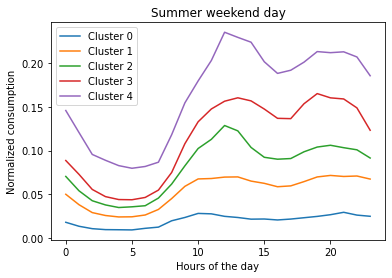

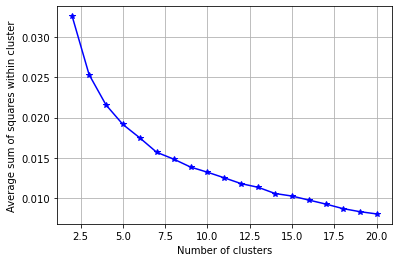

Cluster 0 has 13 clustering members
Cluster 1 has 28 clustering members
Cluster 2 has 27 clustering members
Cluster 3 has 14 clustering members
Cluster 4 has 5 clustering members
Int64Index([6, 13, 21, 1007, 1021], dtype='int64', name='Fall_ge1')


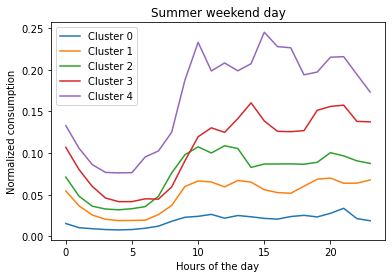

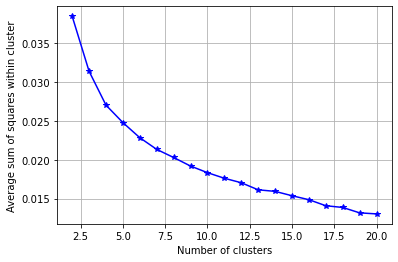

Cluster 0 has 15 clustering members
Cluster 1 has 48 clustering members
Cluster 2 has 31 clustering members
Cluster 3 has 14 clustering members
Cluster 4 has 8 clustering members
Int64Index([558, 614, 637, 655, 684, 1317, 1330, 1354], dtype='int64', name='Fall_ge1')


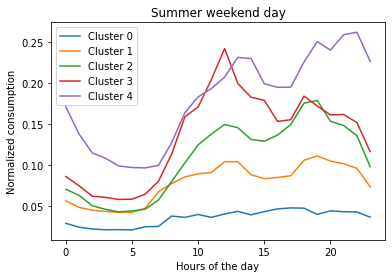

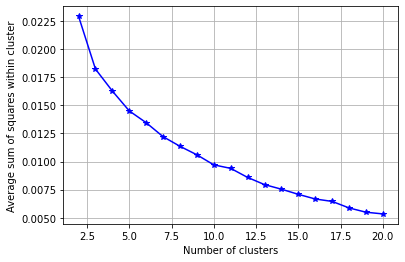

Cluster 0 has 10 clustering members
Cluster 1 has 10 clustering members
Cluster 2 has 15 clustering members
Cluster 3 has 11 clustering members
Cluster 4 has 9 clustering members
Int64Index([102, 105, 118, 122, 133, 145, 147, 1057, 1078], dtype='int64', name='Fall_ge1')


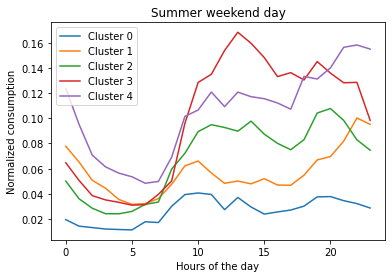

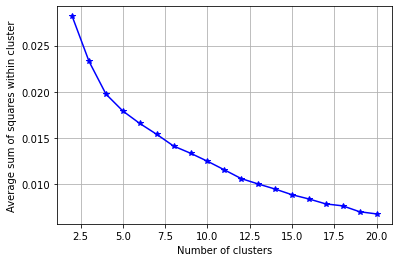

Cluster 0 has 15 clustering members
Cluster 1 has 25 clustering members
Cluster 2 has 18 clustering members
Cluster 3 has 3 clustering members
Cluster 4 has 1 clustering members
Int64Index([178], dtype='int64', name='Fall_ge1')


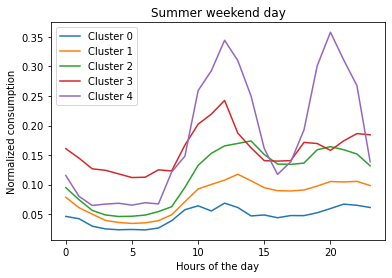

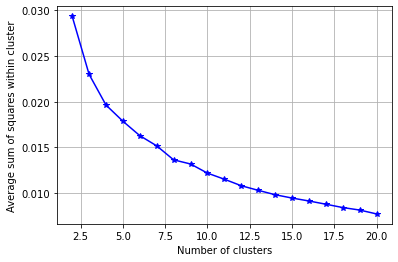

Cluster 0 has 15 clustering members
Cluster 1 has 34 clustering members
Cluster 2 has 29 clustering members
Cluster 3 has 17 clustering members
Cluster 4 has 5 clustering members
Int64Index([285, 325, 372, 1171, 1172], dtype='int64', name='Fall_ge1')


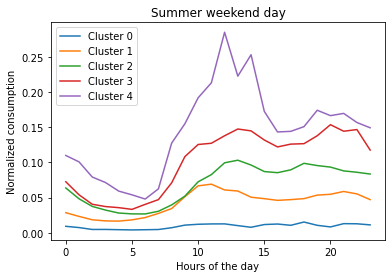

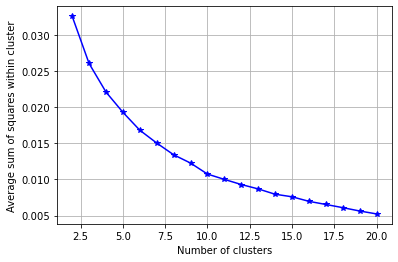

Cluster 0 has 7 clustering members
Cluster 1 has 23 clustering members
Cluster 2 has 7 clustering members
Cluster 3 has 8 clustering members
Cluster 4 has 4 clustering members
Int64Index([465, 480, 488, 492], dtype='int64', name='Fall_ge1')


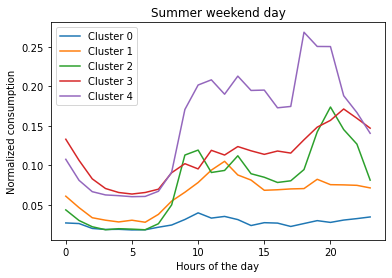

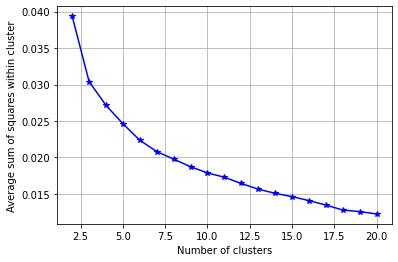

Cluster 0 has 33 clustering members
Cluster 1 has 18 clustering members
Cluster 2 has 24 clustering members
Cluster 3 has 14 clustering members
Cluster 4 has 3 clustering members
Int64Index([1114, 1133, 1161], dtype='int64', name='Fall_ge1')


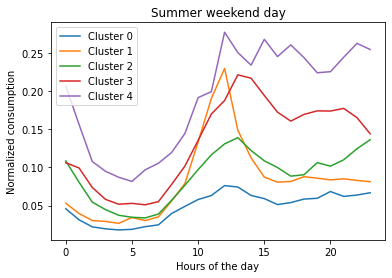

In [71]:
#initiate df for the clustering centers
center_df_su_wknd =pd.DataFrame()

#list for for-loop with all the locations
lst_su_wknd = [df_su_wknd,df_su_wknd_kre,df_su_wknd_mue,df_su_wknd_schw,df_su_wknd_ulm,df_su_wknd_kai,df_su_wknd_cel,df_su_wknd_hass]

#main clustering function for all the locations
for x in lst_su_wknd:
    clust_coef,center_df_su_wknd = elbow_method(x,2,20,"Summer","weekend day",clust_coef,center_df_su_wknd)

In [72]:
center_df_su_wknd_res = center_df_su_wknd.transpose().rename(columns = {0:"all",1:"Krefeld",2:"Münster", 3:"Schwerte",4:"Ulm",5:"Kaiserslautern",6:"Celle",7:"Haßfurt"}).corr()

<AxesSubplot:>

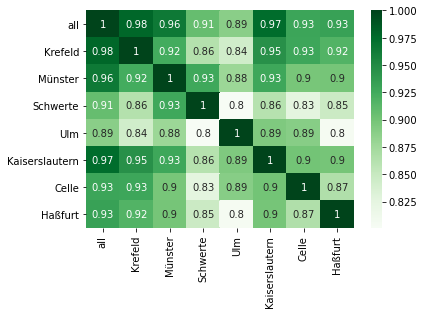

In [73]:
sns.heatmap(center_df_su_wknd_res,annot=True,cmap="Greens")

In [74]:
#coefficient for comparing the clustering similarity: mean of the correlation matrix of all seasons
coef_df_su_wknd = center_df_su_wknd_res.values[np.triu_indices_from(center_df_su_wknd_res.values,1)].mean()
coef_df_su_wknd

0.8972306279177916

In [75]:
(center_df_fa_week_res + center_df_fa_wknd_res + center_df_wi_week_res + center_df_wi_wknd_res +center_df_sp_week_res + center_df_sp_wknd_res + center_df_su_week_res + center_df_su_wknd_res)/8

Celle  Hassfurt  Haßfurt  Kaiserslautern   Krefeld  \
Celle           1.000000       NaN      NaN        0.816109  0.810956   
Hassfurt             NaN       NaN      NaN             NaN       NaN   
Haßfurt              NaN       NaN      NaN             NaN       NaN   
Kaiserslautern  0.816109       NaN      NaN        1.000000  0.884964   
Krefeld         0.810956       NaN      NaN        0.884964  1.000000   
Münster         0.812925       NaN      NaN        0.885099  0.868258   
Schwerte        0.796319       NaN      NaN        0.821457  0.842300   
Ulm             0.760080       NaN      NaN        0.809220  0.801505   
all             0.867734       NaN      NaN        0.931396  0.923831   

                 Münster  Schwerte       Ulm       all  
Celle           0.812925  0.796319  0.760080  0.867734  
Hassfurt             NaN       NaN       NaN       NaN  
Haßfurt              NaN       NaN       NaN       NaN  
Kaiserslautern  0.885099  0.821457  0.809220  0.931396  
Krefeld         0.868258  0.842300  0.801505  0.923831  
Münster         1.000000  0.864835  0.814470  0.925452  
Schwerte        0.864835  1.000000  0.742354  0.871049  
Ulm             0.814470  0.742354  1.000000  0.852379  
all             0.925452  0.871049  0.852379  1.000000

# Cluster correlation coefficient

In [76]:
#over all (mean) cluster correlation
corr_lst = [coef_df_fa_week, coef_df_fa_wknd, coef_df_wi_week, coef_df_wi_wknd, coef_df_sp_week, coef_df_sp_wknd, coef_df_su_wknd,coef_df_su_week]
clust_corr_coef = statistics.fmean(corr_lst)
clust_corr_coef

0.8358688982743707

In [77]:
(coef_df_fa_week+ coef_df_fa_wknd+ coef_df_wi_week+ coef_df_wi_wknd+ coef_df_sp_week+ coef_df_sp_wknd+ coef_df_su_wknd+coef_df_su_week)/8

0.8358688982743707

In [78]:
clust_coef

Silhouette  Calinski-Harabasz  Davies-Bouldin
0     0.778520        6762.752341        0.361005
1     0.795535        1065.405123        0.315880
2     0.754450        1317.326729        0.374582
3     0.816394         799.482759        0.257508
4     0.797288         859.114115        0.295142
..         ...                ...             ...
59    0.835261        1541.641688        0.236645
60    0.802369         687.529013        0.259384
61    0.830171        1604.719427        0.284367
62    0.812499         787.095213        0.272309
63    0.791860        1296.186785        0.328397

[64 rows x 3 columns]

In [79]:
#cluster coefficient for all german households (adjustment because of Haßfurt needed)
clust_coef_all = clust_coef.iloc[::7,:]
clust_coef_all_mean = clust_coef_all.mean()
clust_coef_all_mean

Silhouette              0.785568
Calinski-Harabasz    2142.755772
Davies-Bouldin          0.316003
dtype: float64

In [80]:
clust_coef_all

Silhouette  Calinski-Harabasz  Davies-Bouldin
0     0.778520        6762.752341        0.361005
7     0.775128         434.935622        0.322389
14    0.773225         652.741519        0.281731
21    0.780295        1024.787709        0.297206
28    0.767551         471.985835        0.326199
35    0.799390         702.525596        0.276196
42    0.761432        1410.945928        0.372158
49    0.824384        1584.795579        0.282576
56    0.803897        7085.900802        0.312173
63    0.791860        1296.186785        0.328397

In [81]:
#cluster coefficient for münster (adjustment because of Haßfurt needed)
clust_coef_mue = clust_coef.iloc[2::7,:]
clust_coef_mue

Silhouette  Calinski-Harabasz  Davies-Bouldin
2     0.754450        1317.326729        0.374582
9     0.796475        1053.629137        0.321225
16    0.761223        5293.215246        0.384159
23    0.759920         640.186544        0.351626
30    0.770773         463.418856        0.327030
37    0.815218        1818.059667        0.298811
44    0.799261         843.347920        0.247078
51    0.841851        1286.314402        0.218541
58    0.792312        1337.789614        0.323003

# Connection with survey data 

In [82]:
#import survey data (add path)
survey = pd.read_csv("path to data")

In [83]:
#import data (add path)
descript = pd.read_csv("path to data")

In [86]:
#excluding Linz data
surv_id = survey[survey["ort"]!= "Linz"]

In [87]:
#Change of location
surv_id.Um_Auszug.value_counts()

0    596
1     34
Name: Um_Auszug, dtype: int64

<AxesSubplot:>

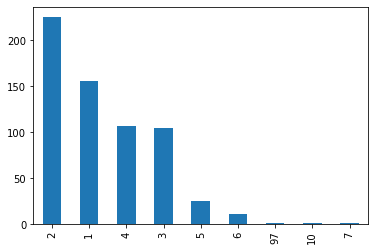

In [88]:
#number of residents
surv_id.q01.value_counts().plot(kind = "bar")

<AxesSubplot:ylabel='q01'>

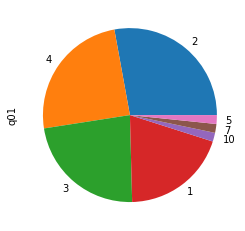

In [89]:
#number of residents for Schwerte
surv_id[surv_id["ort"] == "Schwerte"].q01.value_counts().plot(kind = "pie")

In [90]:
#Number of adults
surv_id.q01a1.value_counts()

2    367
1    173
3     67
4     18
5      4
6      1
Name: q01a1, dtype: int64

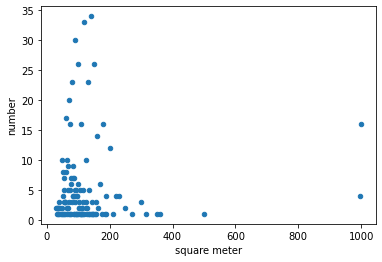

In [91]:
#Size of apartement
surv_id.s07.value_counts()
df_x = surv_id.s07.value_counts().to_frame()
df_x.reset_index(inplace=True)
df_x.columns = ['square meter','number']
df_x.plot(kind='scatter',x='square meter',y='number')
plt.show()

In [92]:
#Household income
surv_id.s08.value_counts()

09_Angabe verweigert             106
02_1.000 bis unter 1.500 Euro     89
03_1.500 bis unter 2.000 Euro     77
04_2.000 bis unter 2.500 Euro     71
01_bis unter 1.000 Euro           70
08_4.000 Euro und mehr            69
05_2.500 bis unter 3.000 Euro     56
06_3.000 bis unter 3.500 Euro     41
07_3.500 bis unter 4.000 Euro     28
10_weiß nicht                     23
Name: s08, dtype: int64

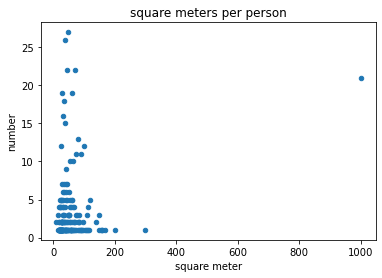

In [93]:
#Size of apartement per person
surv_id.s07pp.value_counts()
df_x = surv_id.s07pp.value_counts().to_frame()
df_x.reset_index(inplace=True)
df_x.columns = ['square meter','number']
df_x.plot(kind='scatter',x='square meter',y='number')
plt.title("square meters per person")
plt.show()

In [94]:
#Employment status
surv_id.ewstatus.value_counts()

01_berufstätig               375
02_nicht mehr berufstätig    175
04_Hausfrau/-mann             38
05_ohne Beschäftigung         22
03_in der Ausbildung          15
06_Antwort verweigert          4
07_weiß nicht                  1
Name: ewstatus, dtype: int64

In [95]:
surv_red = surv_id[["Fall_ge","ort","Um_Auszug","q01","q01a1","s07","s08","s07pp","ewstatus","berufst"]]

# Connection of locations with survey data

In [96]:
#funktion for plotting mean of different cities to compare them
def mean_plot_location (df,String):
    red_df=df[["hour","norm_energy","Daten_Herkunft"]]
    loc_lst=["Münster","Schwerte","Krefeld"]
    plt.plot(red_df.groupby("hour").mean(), label ="All locations")
    for loc in loc_lst:
        loc_df = red_df[red_df["Daten_Herkunft"]== loc].groupby("hour").mean()
        plt.plot(loc_df, label = loc)
    plt.legend()
    plt.title(String + " mean of diffeerent locations")

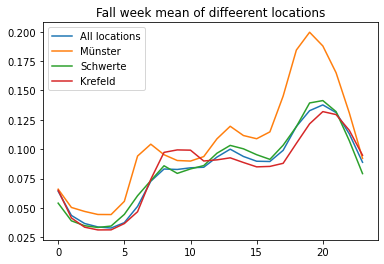

In [97]:
mean_plot_location(df_fa_week,"Fall week")

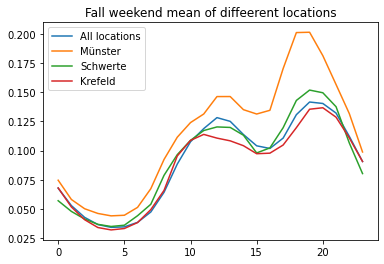

In [98]:
mean_plot_location(df_fa_wknd,"Fall weekend")

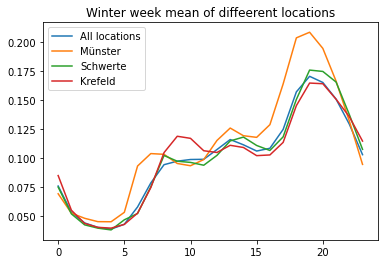

In [99]:
mean_plot_location(df_wi_week,"Winter week")

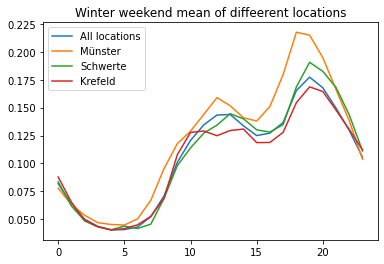

In [100]:
mean_plot_location(df_wi_wknd, "Winter weekend")

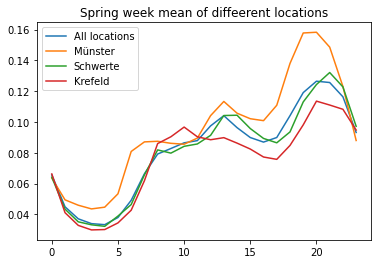

In [101]:
mean_plot_location(df_sp_week, "Spring week")

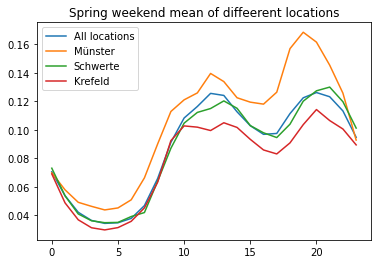

In [102]:
mean_plot_location(df_sp_wknd, "Spring weekend")

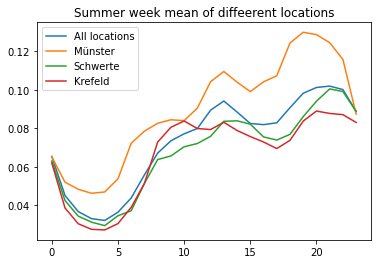

In [103]:
mean_plot_location(df_su_week, "Summer week")

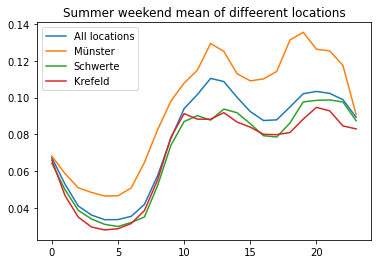

In [104]:
mean_plot_location(df_su_wknd, "Summer weekend")

In [105]:
#function to plot household members working status among the locations
def survey_employment (df_surv,location):
    if location == "all":
        pass
    else:
        df_surv = df_surv[df_surv["ort"] == location]
                          
    #number of adults
    num_adlt = df_surv[df_surv["q01a1"]<= 10].q01a1.value_counts().sort_index()
    #number of full-time working residents
    num_full = df_surv.s03a.value_counts().sort_index()
    #number of half-time working residents
    num_half = df_surv.s03b.value_counts().sort_index()
    #number of unemployed residents
    num_uepl = df_surv.s03c.value_counts().sort_index()
    #number of retired residents
    num_ret = df_surv.s03d.value_counts().sort_index() 
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    #number of residents as pie plot
    num_adlt.plot(ax=axs[0], kind = "pie",title = "Adult residents")
    num_full.plot(ax=axs[1], kind = "pie",title = "Full-time working residents")
    num_half.plot(ax=axs[2], kind = "pie",title = "Half-time working residents")
    num_uepl.plot(ax=axs[3], kind = "pie",title = "Unemployed residents")
    num_ret.plot(ax=axs[4], kind = "pie",title = "Retired residents")
    fig.suptitle('Plotting of categorical variables of ' + location)
    

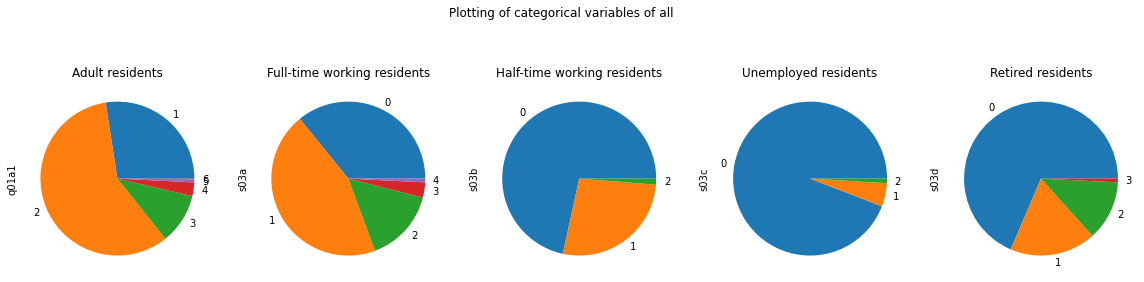

In [106]:
survey_employment(surv_id,"all")

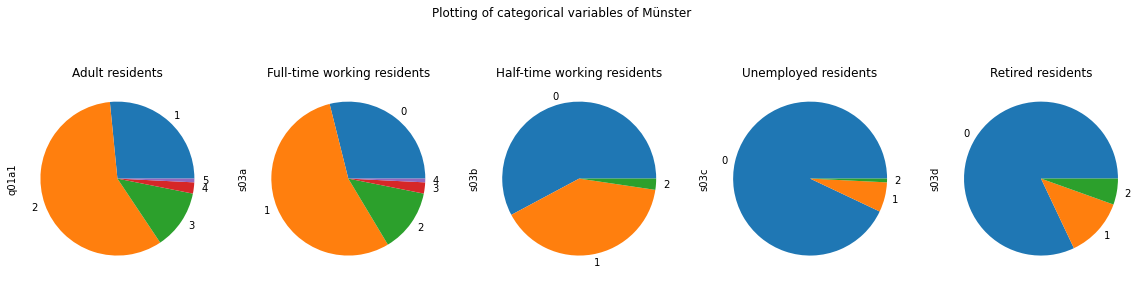

In [107]:
survey_employment(surv_id,"Münster")

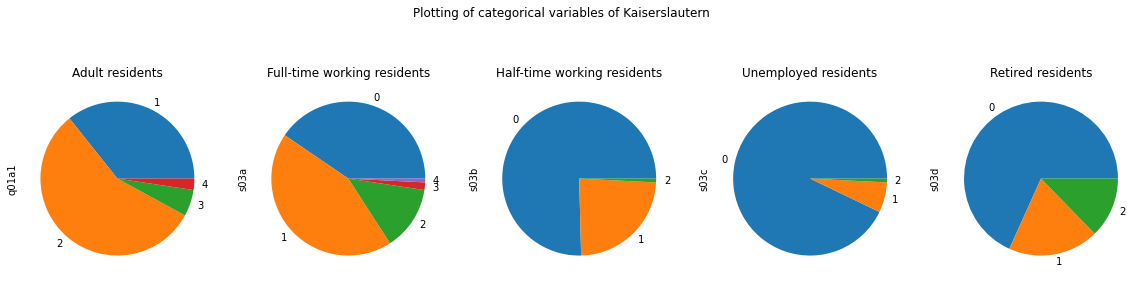

In [108]:
survey_employment(surv_id,"Kaiserslautern")

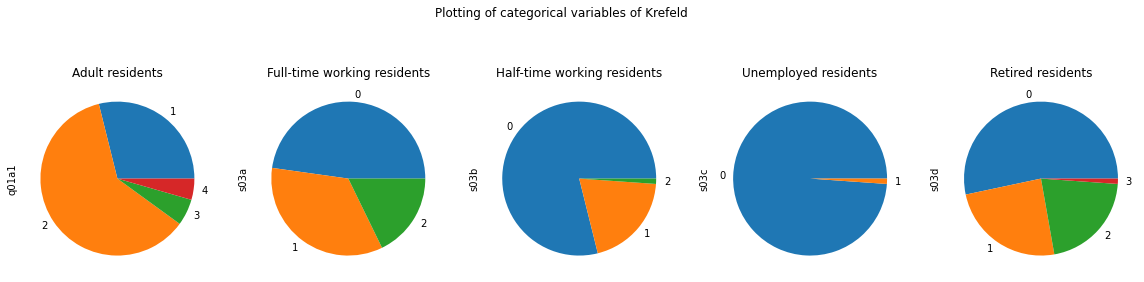

In [109]:
survey_employment(surv_id,"Krefeld")

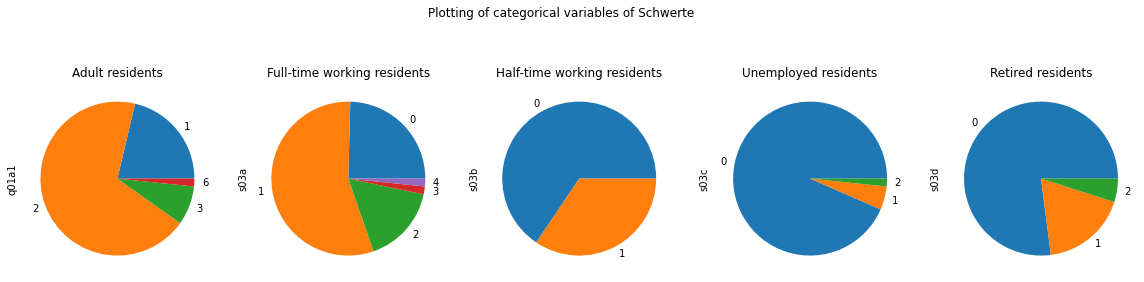

In [110]:
survey_employment(surv_id,"Schwerte")

# Determine cluster number with other indices (SIL & DBI)

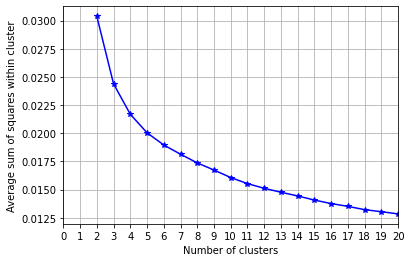

Text(0, 0.5, 'Silhouette score')

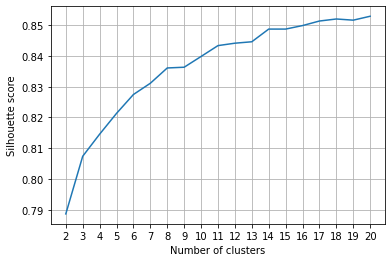

In [111]:
    #cluster approach with k-means simmilar to the function "elbow_method" but more flexible
    red_df=df[["Fall_ge1","day_of_year","hour","norm_energy"]]
    piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
    piv_df.reset_index(inplace = True)
    grp_df = piv_df.groupby("Fall_ge1").mean()
    #grp_df.reset_index(inplace = True)
    del grp_df["day_of_year"]
    kmeans_df = grp_df
    #check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
    if "cluster" in kmeans_df:
        del kmeans_df["cluster"]
    
    min_k = 2
    max_k = 20
    
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k,n_init=100) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(kmeans_df) for alg in k_mean_algs]
    
        # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(kmeans_df, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    x = np.arange(0,21,1)
    values = range(len(x))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-',scalex=False)
    plt.xticks(values,x)
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show() 
    
    # Plot the graph for the silhouette coeff with number of clusters
    coef_lst=[]
    for k in range(2,21):
        labels_coef = k_mean_res[k-2].labels_
        clustering = k_mean_res[k-2]
        kmeans_df['cluster'] = list(clustering.labels_)
        
        #different coefficients: change in "coef_lst" necessary if changed
        sil_coef = metrics.silhouette_score(kmeans_df, labels_coef, metric='euclidean')
        #cal_har = metrics.calinski_harabasz_score(kmeans_df, labels_coef)
        #db_ind = metrics.davies_bouldin_score(kmeans_df, labels_coef)
        coef_lst.append(sil_coef)
        
    x = np.arange(2,21,1)
    values = range(len(x))
    plt.plot(coef_lst)
    plt.xticks(values,x)
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')  

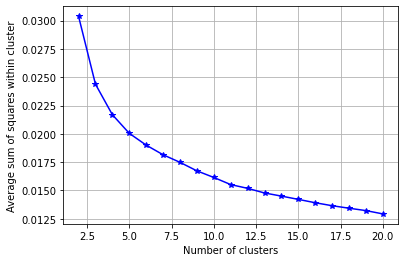

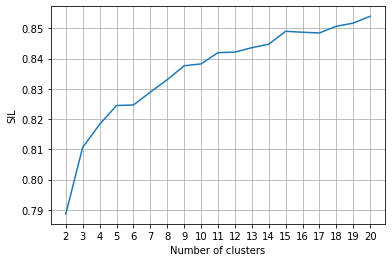

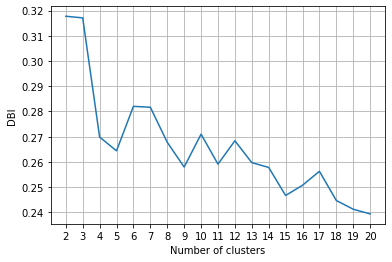

In [112]:
    #reshape df
    red_df=df[["Fall_ge1","day_of_year","hour","norm_energy"]]
    piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
    piv_df.reset_index(inplace = True)
    grp_df = piv_df.groupby("Fall_ge1").mean()
    #grp_df.reset_index(inplace = True)
    del grp_df["day_of_year"]
    kmeans_df = grp_df
    #check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
    if "cluster" in kmeans_df:
        del kmeans_df["cluster"]
    
    min_k = 2
    max_k = 20
    
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k,n_init=10,max_iter=500) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(kmeans_df) for alg in k_mean_algs]
    
        # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(kmeans_df, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    # Plot the graph for the silhouette coeff with number of clusters
    coef_lst=[]
    db_lst=[]
    for k in range(2,21):
        labels_coef = k_mean_res[k-2].labels_
        clustering = k_mean_res[k-2]
        kmeans_df['cluster'] = list(clustering.labels_)
        
        #different coefficients: change in "coef_lst" necessary if changed
        sil_coef = metrics.silhouette_score(kmeans_df, labels_coef, metric='euclidean')
        #cal_har = metrics.calinski_harabasz_score(kmeans_df, labels_coef)
        db_ind = metrics.davies_bouldin_score(kmeans_df, labels_coef)
        coef_lst.append(sil_coef)
        db_lst.append(db_ind)
        
    x = np.arange(2,21,1)
    values = range(len(x))
    plt.plot(coef_lst)
    plt.xticks(values,x)
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('SIL')
    plt.show()
    
    y = np.arange(2,21,1)
    values = range(len(y))
    plt.plot(db_lst)
    plt.xticks(values,y)
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('DBI')
    plt.show()

        
    
    algorithm = k_mean_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 5 corresponds to the element with index 3
    clustering = k_mean_res[3]
    
    #reassign cluster numbers so the cluster numbers are from lowest to highest mean
    k=5
    #order of clustering centers by mean (idx)
    idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
    #"key" to convert count from 1 to 5 to the order regarding the mean (lut)
    lut = np.zeros_like(idx)
    
    lut[idx] = np.arange(k)
    
    #assign cluster labels odered by mean to dataframe
    kmeans_df['cluster'] = list(lut[clustering.labels_])
    
    #order clustering centers by mean
    clust_cent = clustering.cluster_centers_[idx]


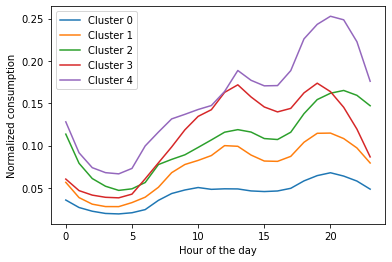

In [113]:
    #plot clustering centers with normalized consumption
    for x in range(0,5,1):
        plt.plot(clust_cent[x],label = "Cluster " + str(x),linewidth = 1.5)  
        plt.legend()
        plt.ylabel("Normalized consumption")
        plt.xlabel("Hour of the day")

In [114]:
sil_coef

0.8539755472604016

In [115]:
db_ind

0.23937816252136965

# Location share among the clustering approach with 5 clusters

In [116]:
#Data frame with ids from german data:
survey_ger = survey[survey["Fall_ge"].isin(list(kmeans_df.index))]

In [117]:
#expected location share of german households
loc_share_df = pd.DataFrame(survey_ger.ort.value_counts()/len(survey_ger.index.unique()))
#loop for all share of all clusters (k=10)
for x in range(0,5):
    lst = list(kmeans_df[kmeans_df["cluster"]==x].index) 
    df_support = pd.DataFrame(survey[survey["Fall_ge"].isin(lst)].ort.value_counts()/len(survey[survey["Fall_ge"].isin(lst)]))
    df_support.columns = ["Cluster_" + str(x)]
    loc_share_df = loc_share_df.join(df_support)
loc_share_df
    #print("Cluster " + str(x)+ " contains " + str(survey[survey["Fall_ge"].isin(lst)].ort.value_counts()))

ort  Cluster_0  Cluster_1  Cluster_2  Cluster_3  \
Münster         0.208185   0.123077   0.174603   0.114583   0.333333   
Kaiserslautern  0.177936   0.346154   0.174603   0.114583   0.088889   
Hassfurt        0.163701   0.123077   0.185185   0.239583   0.100000   
Krefeld         0.154804   0.153846   0.190476   0.177083   0.100000   
Ulm             0.110320   0.076923   0.105820   0.145833   0.133333   
Schwerte        0.097865   0.092308   0.084656   0.135417   0.122222   
Celle           0.087189   0.084615   0.084656   0.072917   0.122222   

                Cluster_4  
Münster          0.473684  
Kaiserslautern   0.052632  
Hassfurt         0.157895  
Krefeld          0.087719  
Ulm              0.105263  
Schwerte         0.052632  
Celle            0.070175

In [118]:
#differnece of location share within cluster to location share in dataset:
loc_share_diff = pd.DataFrame()
for x in range(0,5):
    loc_share_diff["cluster_" + str(x)] = loc_share_df["Cluster_" + str(x)]-loc_share_df.ort

In [119]:
#absolute difference + Latex conversion
loc_share_diff.abs().to_latex()#.mean(axis = 1).mean()

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  cluster\\_0 &  cluster\\_1 &  cluster\\_2 &  cluster\\_3 &  cluster\\_4 \\\\\n\\midrule\nMünster        &   0.085108 &   0.033582 &   0.093602 &   0.125148 &   0.265499 \\\\\nKaiserslautern &   0.168218 &   0.003333 &   0.063353 &   0.089047 &   0.125304 \\\\\nHassfurt       &   0.040624 &   0.021484 &   0.075882 &   0.063701 &   0.005806 \\\\\nKrefeld        &   0.000958 &   0.035672 &   0.022279 &   0.054804 &   0.067085 \\\\\nUlm            &   0.033397 &   0.004500 &   0.035513 &   0.023013 &   0.005057 \\\\\nSchwerte       &   0.005557 &   0.013209 &   0.037552 &   0.024357 &   0.045233 \\\\\nCelle          &   0.002573 &   0.002533 &   0.014272 &   0.035034 &   0.017013 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [120]:
#print latex code
print(loc_share_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &       ort &  Cluster\_0 &  Cluster\_1 &  Cluster\_2 &  Cluster\_3 &  Cluster\_4 \\
\midrule
Münster        &  0.208185 &   0.123077 &   0.174603 &   0.114583 &   0.333333 &   0.473684 \\
Kaiserslautern &  0.177936 &   0.346154 &   0.174603 &   0.114583 &   0.088889 &   0.052632 \\
Hassfurt       &  0.163701 &   0.123077 &   0.185185 &   0.239583 &   0.100000 &   0.157895 \\
Krefeld        &  0.154804 &   0.153846 &   0.190476 &   0.177083 &   0.100000 &   0.087719 \\
Ulm            &  0.110320 &   0.076923 &   0.105820 &   0.145833 &   0.133333 &   0.105263 \\
Schwerte       &  0.097865 &   0.092308 &   0.084656 &   0.135417 &   0.122222 &   0.052632 \\
Celle          &  0.087189 &   0.084615 &   0.084656 &   0.072917 &   0.122222 &   0.070175 \\
\bottomrule
\end{tabular}



In [121]:
#check number of cluster membership 
#kmeans_df["cluster"].value_counts()

In [122]:
#sil and db coef for all year data to compare with other clustering algorithms
labels = clustering.labels_
sil_coef = metrics.silhouette_score(kmeans_df, labels, metric='euclidean')
db_ind = metrics.davies_bouldin_score(kmeans_df, labels)  

In [123]:
survey_ger[survey_ger["Fall_ge"].isin(lst)].ort.value_counts()/len(survey_ger[survey_ger["Fall_ge"].isin(lst)])

Münster           0.473684
Hassfurt          0.157895
Ulm               0.105263
Krefeld           0.087719
Celle             0.070175
Schwerte          0.052632
Kaiserslautern    0.052632
Name: ort, dtype: float64

### Compare survey data characteristics within the clusters 

In [124]:
#survey_ger[survey_ger["Fall_ge"].isin(lst)].s07.isnull().value_counts()#/len(survey_ger[survey_ger["Fall_ge"].isin(lst)])

In [125]:
#print area share among the clusters
for x in range(0,5):
    lst = list(kmeans_df[kmeans_df["cluster"]==x].index) 
    ist_support = [survey[survey["Fall_ge"].isin(lst)].s07.mean()]
    print("Average household area of cluster " + str(x) + str(ist_support))
    #area_share_df = loc_share_df.join(ist_support)
#area_share_df

Average household area of cluster 0[115.09615384615384]
Average household area of cluster 1[134.3994708994709]
Average household area of cluster 2[161.90625]
Average household area of cluster 3[157.01111111111112]
Average household area of cluster 4[132.56140350877192]


In [126]:
#print mean energy consumption in the clusters
for x in range(0,5):
    lst = list(kmeans_df[kmeans_df["cluster"]==x].index) 
    lst_support = [df[df["Fall_ge1"].isin(lst)].Electricity_Demand.mean()]
    print("Average electricity demand " + str(x) + str(lst_support))
    #area_share_df = loc_share_df.join(ist_support)
#area_share_df

Average electricity demand 0[205.39469546577962]
Average electricity demand 1[346.49152518880834]
Average electricity demand 2[436.705832390693]
Average electricity demand 3[486.19963456403894]
Average electricity demand 4[586.4820528085166]


In [127]:
#mean energy within cluster to list:
cluster_list = ["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"]
energy_list =[]
for x in range(0,len(cluster_list)):
    lst = list(kmeans_df[kmeans_df["cluster"]==x].index) 
    energy_list.append(df[df["Fall_ge1"].isin(lst)].Electricity_Demand.mean())

In [128]:
#area within locations to list:
location_list = ["Krefeld","Münster","Schwerte","Ulm","Kaiserslautern","Celle","Hassfurt"]
area_list =[]
for x in range(0,len(location_list)):
    area_list.append(survey[survey["ort"]== location_list[x]].s07.mean())

In [129]:
#convert to data frame
area_df = pd.DataFrame({"Location":location_list,"Flor area":area_list})

In [130]:
#mean energy by location to list:
location_list = ["Krefeld","Münster","Schwerte","Ulm","Kaiserslautern","Celle","Hassfurt"]
Electricity_list =[]
for x in range(0,len(location_list)):
    Electricity_list.append(df[df["Daten_Herkunft"]== location_list[x]].Electricity_Demand.mean())

# Dataset combination

In [131]:
#import CoSSMic data from file created with the CoSSMic data processing script
df_cossmic = pd.read_pickle("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/COssMic datensatz/opsd-household_data-2020-04-15/df_cossmic.pkl")

In [132]:
#labels and lists for the plots
labels_import_norm = ["Import 1","Import 2","Import 3","Import 4","Import 5","Import 6"]
label_import = ["reident 1", "resident 2", "resident 3", "resident 4", "resident 5", "resident 6"]
list_import_norm = ["DE_KN_residential1_grid_import_norm","DE_KN_residential2_grid_import_norm","DE_KN_residential3_grid_import_norm","DE_KN_residential4_grid_import_norm","DE_KN_residential5_grid_import_norm","DE_KN_residential6_grid_import_norm"]
list_import = ["DE_KN_residential1_grid_import","DE_KN_residential2_grid_import","DE_KN_residential3_grid_import","DE_KN_residential4_grid_import","DE_KN_residential5_grid_import","DE_KN_residential6_grid_import"]
list_cons_norm = ["DE_KN_residential1_grid_import_norm","DE_KN_residential2_grid_import_norm","consumption_3_norm","consumption_4_norm","DE_KN_residential5_grid_import_norm","DE_KN_residential6_grid_import_norm"]

In [133]:
#Meteorological seasons (not perfectly suitable for resident 2, data ending from feb 2017): 
#spring
sdate_sp = date(2016, 3, 1)   # start date
edate_sp = date(2016, 5, 31)   # end date
#summer
sdate_su = date(2016, 6, 1)   # start date
edate_su = date(2016, 8, 31)   # end date
#Fall
sdate_fa = date(2016, 9, 1)   # start date
edate_fa = date(2016, 11, 30)   # end date
#winter
sdate_wi = date(2016, 12, 1)   # start date
edate_wi = date(2017, 2, 28)   # end date

In [134]:
#split df_cossmic  to seasons
df_fa_coss = df_cossmic[str(sdate_fa):str(edate_fa)]
df_wi_coss = df_cossmic[str(sdate_wi):str(edate_wi)]
df_sp_coss = df_cossmic[str(sdate_sp):str(edate_sp)]
df_su_coss = df_cossmic[str(sdate_su):str(edate_su)]

In [135]:
#list for week/wknd slicing
week = [0,1,2,3,4]
wknd = [5,6]

In [136]:
#week/wknd slicing
df_fa_coss_week = df_fa_coss[df_fa_coss.day_of_week.isin(week)]
df_wi_coss_week = df_wi_coss[df_wi_coss.day_of_week.isin(week)]
df_sp_coss_week = df_sp_coss[df_sp_coss.day_of_week.isin(week)]
df_su_coss_week = df_su_coss[df_su_coss.day_of_week.isin(week)]

df_fa_coss_wknd = df_fa_coss[df_fa_coss.day_of_week.isin(wknd)]
df_wi_coss_wknd = df_wi_coss[df_wi_coss.day_of_week.isin(wknd)]
df_sp_coss_wknd = df_sp_coss[df_sp_coss.day_of_week.isin(wknd)]
df_su_coss_wknd = df_su_coss[df_su_coss.day_of_week.isin(wknd)]

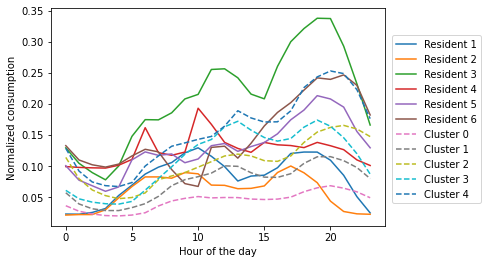

In [137]:
label_combination = ["Resident 1","Resident 2","Resident 3","Resident 4","Resident 5","Resident 6","Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 4"]
for x in list_cons_norm:
    plt.plot(df_cossmic[x].groupby(df_cossmic.index.hour).mean())  
for x in range(0,5,1):
    plt.plot(clust_cent[x],"--",label = "Cluster " + str(x),linewidth = 1.5)  
    plt.ylabel("Normalized consumption")
    plt.xlabel("Hour of the day")
plt.legend(label_combination,bbox_to_anchor =(1.3,0.9))

# Hierarchical clustering 

In [138]:
    #reshape df
    hierarch_df=df[["Fall_ge1","day_of_year","hour","norm_energy"]]
    piv_df = pd.pivot_table(hierarch_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
    piv_df.reset_index(inplace = True)
    grp_df = piv_df.groupby("Fall_ge1").mean()
    #grp_df.reset_index(inplace = True)
    del grp_df["day_of_year"]
    kmeans_df = grp_df
    #check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
    if "cluster" in kmeans_df:
        del kmeans_df["cluster"]

In [139]:
hier_clust = cluster.AgglomerativeClustering(n_clusters = 5,linkage = "ward").fit(kmeans_df)

In [140]:
#plot_dendrogram(hier_clust, truncate_mode='level', p=3)

In [141]:
hier_clust.labels_

array([2, 2, 2, 1, 1, 1, 1, 4, 2, 3, 4, 3, 2, 2, 3, 1, 2, 3, 0, 0, 0, 0,
       2, 0, 1, 2, 1, 0, 2, 0, 4, 4, 0, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0,
       3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 4, 2, 1, 1, 1, 2, 1, 3, 4, 0, 2, 1,
       2, 2, 0, 4, 1, 4, 0, 4, 1, 4, 1, 0, 0, 1, 2, 0, 2, 0, 3, 0, 0, 0,
       2, 3, 1, 1, 2, 0, 0, 1, 1, 1, 4, 2, 1, 0, 2, 4, 2, 0, 3, 2, 2, 1,
       0, 2, 1, 1, 4, 2, 0, 1, 4, 2, 4, 2, 4, 2, 4, 1, 2, 3, 2, 4, 0, 3,
       0, 2, 0, 0, 1, 2, 4, 0, 0, 2, 2, 2, 2, 4, 2, 4, 0, 0, 0, 1, 4, 4,
       2, 0, 1, 4, 3, 1, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 2, 0, 0, 2, 0, 4, 0, 1, 0, 2, 2, 0, 2, 0, 0, 0, 2, 4, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 1, 4, 0, 0, 0, 2, 0,
       0, 0, 1, 4, 1, 3, 1, 0, 2, 2, 4, 2, 1, 3, 0, 0, 4, 1, 1, 1, 4, 2,
       3, 0, 0, 2, 4, 0, 2, 2, 1, 0, 0, 0, 0, 0, 3, 2, 4, 2, 0, 2, 0, 1,
       0, 2, 1, 0, 0, 2, 0, 3, 1, 1, 2, 1, 3, 0, 1, 0, 0, 1, 4, 1, 0, 0,
       1, 3, 0, 0, 0, 2, 0, 2, 0, 1, 2, 3, 0, 0, 0,

In [142]:
len(hier_clust.labels_)

562

In [143]:
sil_coef = metrics.silhouette_score(kmeans_df,hier_clust.labels_, metric='euclidean')
#cal_har = metrics.calinski_harabasz_score(kmeans_df, labels_coef)
db_ind = metrics.davies_bouldin_score(kmeans_df, hier_clust.labels_)

In [144]:
sil_coef

0.16315412414766997

In [145]:
db_ind

1.6927799165861757

# Fuzzy clustering

In [147]:
x = np.arange(11)
mfx = fuzz.trimf(x, [0, 5, 10])

In [148]:
mfx

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. ])

In [149]:
    #reshape df
    red_df=df[["Fall_ge1","day_of_year","hour","norm_energy"]]
    piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
    piv_df.reset_index(inplace = True)
    grp_df = piv_df.groupby("Fall_ge1").mean()
    #grp_df.reset_index(inplace = True)
    del grp_df["day_of_year"]
    kmeans_df = grp_df
    #check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
    if "cluster" in kmeans_df:
        del kmeans_df["cluster"]
    
    min_k = 2
    max_k = 10
    
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)  
    kmeans_df = kmeans_df.transpose()
    
    ind_mat = [[],[],[],[],[],[],[]]
    count = 0
    for x in np.arange(1.01,1.31,0.05):
        for k in cluster_nums:
            fuzzy = fuzz.cluster.cmeans(kmeans_df,c = k,m = x,error = 0.00001,maxiter = 200)
            ind_mat[count].append(fuzzy[6])
        count +=1    

In [150]:
fuzzy
#np.arange(1.01,1.31,0.05)

(array([[0.02794854, 0.02113479, 0.01798163, 0.01572545, 0.01539213,
         0.01674281, 0.02022155, 0.02894168, 0.03544087, 0.04056946,
         0.04270527, 0.04086076, 0.04126538, 0.0405564 , 0.03776625,
         0.03586713, 0.03616505, 0.03893573, 0.04604339, 0.05170449,
         0.05741417, 0.05281854, 0.04648982, 0.03869815],
        [0.06125753, 0.04436955, 0.03751154, 0.03491876, 0.03433428,
         0.03871792, 0.050818  , 0.06832977, 0.0867329 , 0.10571408,
         0.1169972 , 0.12625835, 0.14538529, 0.15483253, 0.14186539,
         0.12932126, 0.12285619, 0.1268257 , 0.14158665, 0.15115184,
         0.14618944, 0.13465626, 0.11457522, 0.08719357],
        [0.08462977, 0.06013177, 0.04988129, 0.04553533, 0.04389036,
         0.04707031, 0.06317747, 0.08167918, 0.09338178, 0.10314285,
         0.11271243, 0.11975982, 0.1319554 , 0.14125928, 0.13527247,
         0.12912961, 0.12867901, 0.143729  , 0.17255767, 0.18896917,
         0.18546784, 0.17454544, 0.15243121, 0.12114589]

In [151]:
#ind_mat
#ind = [[],[]]
#20+19+18+17+16+15+14+13+12+11+10+9+8+7+6+5+4+3+2
#cluster_nums
#19*5
ind_ar = np.array(ind_mat)
ind_ar

array([[0.99694609, 0.9985869 , 0.99640399, 0.99689366, 0.99792153,
        0.99799797, 0.99870472, 0.99868541, 0.99832395],
       [0.98453293, 0.97719375, 0.96549722, 0.9634468 , 0.95915381,
        0.95269337, 0.95248805, 0.94975351, 0.95102983],
       [0.97117138, 0.95268544, 0.93079215, 0.92267815, 0.90146034,
        0.89444441, 0.89042724, 0.89191509, 0.87932648],
       [0.95681295, 0.92776715, 0.89434693, 0.87972143, 0.84538578,
        0.83080666, 0.8216446 , 0.81527362, 0.81036528],
       [0.94197968, 0.90146016, 0.85727879, 0.83514418, 0.79092411,
        0.77050907, 0.75819981, 0.75150603, 0.74538771],
       [0.92669136, 0.87387871, 0.81979248, 0.78884703, 0.73858041,
        0.71924098, 0.69535439, 0.68525832, 0.67321373],
       [0.91088906, 0.84544812, 0.78242143, 0.74124648, 0.6878795 ,
        0.66296647, 0.63498819, 0.61994814, 0.60393236]])

In [152]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

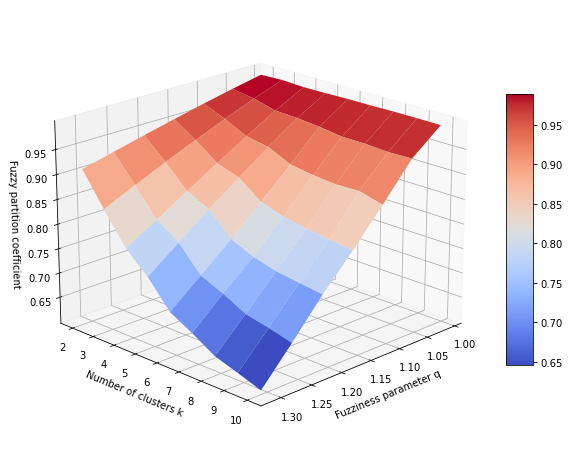

In [153]:
#set up grid
x = np.arange(1.01,1.31,0.05)
y = np.arange(2,11,1)

data = ind_ar

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
surf = ax.plot_surface(X.T, Y.T, data,cmap=cm.coolwarm)
# rotate the axes and update
ax.view_init(20, 45)

    
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

#Axis labels
ax.set_ylabel("Number of clusters k")
ax.set_xlabel("Fuzziness parameter q")
ax.set_zlabel("Fuzzy partition coefficient")

plt.show()

In [154]:
    ind_lst = []
    for k in cluster_nums:
        fuzzy = fuzz.cluster.cmeans(kmeans_df,c = k,m = 1.1,error = 0.0001,maxiter = 100)
        ind_lst.append(fuzzy[6])

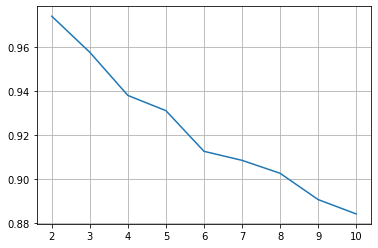

In [155]:
plt.plot(ind_lst)
x = np.arange(2,11,1)
values = range(len(x))
plt.xticks(values,x)
plt.grid(True)

In [156]:
fuzzy = fuzz.cluster.cmeans(kmeans_df,c = 5,m = 1.3,error = 0.0001,maxiter = 300)

In [157]:
#defuzification with highest possibility as cluster membership
clust_lst_fuzz = [] #list with cluster membership
fuzz_trans = fuzzy[1].transpose() 

#search for max in cluster membership
for x in range(len(fuzzy[1][1])):
    array = np.where(fuzz_trans[x] == fuzz_trans[x].max())
    cluster_number = array[0][0]
    clust_lst_fuzz.append(cluster_number)

In [158]:
#fuzzy df for determininig validation coefficients
cmeans_df = kmeans_df.copy()

In [159]:
cmeans_df

Fall_ge1      1         2         3         4         5         6     \
hour                                                                   
0         0.059210  0.106479  0.097360  0.042725  0.093542  0.028785   
1         0.032082  0.076039  0.084643  0.037066  0.070417  0.027923   
2         0.023786  0.061991  0.079103  0.035925  0.057151  0.027033   
3         0.022630  0.059412  0.077856  0.033470  0.049933  0.027239   
4         0.021726  0.061012  0.077322  0.050501  0.047167  0.027456   
5         0.024598  0.060784  0.078446  0.080627  0.046130  0.027730   
6         0.036536  0.061417  0.077683  0.041877  0.048392  0.066525   
7         0.047385  0.060615  0.074720  0.046528  0.052918  0.106748   
8         0.073877  0.088894  0.077205  0.067070  0.050484  0.117605   
9         0.080899  0.128296  0.089338  0.094375  0.071945  0.225449   
10        0.090504  0.126621  0.093702  0.101804  0.109133  0.334326   
11        0.101011  0.115789  0.102540  0.107585  0.108484  0.188192   
12        0.097071  0.115022  0.101128  0.120745  0.104612  0.129180   
13        0.097758  0.179881  0.101682  0.155216  0.130748  0.103674   
14        0.096554  0.138922  0.102830  0.140498  0.189027  0.061813   
15        0.075654  0.105494  0.108597  0.120733  0.194620  0.184524   
16        0.067105  0.094561  0.104594  0.109084  0.181272  0.158744   
17        0.086705  0.088739  0.100623  0.106216  0.137644  0.116940   
18        0.092870  0.094187  0.103181  0.116561  0.131200  0.129028   
19        0.087494  0.102906  0.110463  0.131918  0.129729  0.110132   
20        0.088858  0.106542  0.117803  0.133859  0.141672  0.106324   
21        0.082720  0.107089  0.122219  0.115125  0.150843  0.108006   
22        0.081577  0.111165  0.124123  0.087898  0.146506  0.115577   
23        0.080454  0.111902  0.117056  0.058796  0.124417  0.034662   

Fall_ge1      9         10        12        13    ...      1360      1361  \
hour                                              ...                       
0         0.040453  0.158150  0.099526  0.104553  ...  0.036778  0.067753   
1         0.020701  0.116604  0.084923  0.081579  ...  0.033889  0.038401   
2         0.015528  0.064809  0.045094  0.077185  ...  0.034093  0.033527   
3         0.014688  0.045232  0.030423  0.077480  ...  0.034690  0.032681   
4         0.015112  0.038106  0.028547  0.077017  ...  0.038823  0.031844   
5         0.017154  0.048634  0.028875  0.080321  ...  0.038451  0.030988   
6         0.020888  0.067067  0.028291  0.082759  ...  0.065870  0.093338   
7         0.026849  0.051098  0.028311  0.123345  ...  0.069481  0.080019   
8         0.037799  0.064045  0.059387  0.173044  ...  0.083927  0.111494   
9         0.060949  0.127630  0.133169  0.218730  ...  0.079582  0.085820   
10        0.097003  0.210679  0.153086  0.202539  ...  0.077594  0.086994   
11        0.109946  0.171311  0.111803  0.193168  ...  0.079779  0.092882   
12        0.120768  0.097833  0.224371  0.189502  ...  0.075164  0.157216   
13        0.144540  0.081981  0.140112  0.236901  ...  0.100721  0.202360   
14        0.149142  0.083768  0.067741  0.170998  ...  0.083607  0.164971   
15        0.128528  0.085108  0.057612  0.158923  ...  0.081356  0.182129   
16        0.137631  0.088139  0.054559  0.163153  ...  0.087214  0.157264   
17        0.116640  0.093169  0.058006  0.157863  ...  0.096776  0.170851   
18        0.127789  0.134844  0.078157  0.153872  ...  0.153338  0.197119   
19        0.262200  0.178286  0.098385  0.151529  ...  0.162992  0.204666   
20        0.237004  0.176165  0.098539  0.154396  ...  0.122766  0.226669   
21        0.223868  0.159845  0.091537  0.132955  ...  0.102734  0.192472   
22        0.119148  0.154941  0.098384  0.136377  ...  0.084715  0.144368   
23        0.083210  0.161594  0.103755  0.144640  ...  0.048738  0.111311   

Fall_ge1      1362      1363      1364      1365      1366      1367  \
hour                                                

In [160]:
#silouette coefficient fuzzy
sil_coef_fuzz = metrics.silhouette_score(cmeans_df.transpose(),clust_lst_fuzz, metric='euclidean')
sil_coef_fuzz

0.19533242292812603

In [161]:
#Davies-Bouldin Index
db_coef_fuzz = metrics.davies_bouldin_score(cmeans_df.transpose(),clust_lst_fuzz)
db_coef_fuzz

1.5986461265008265

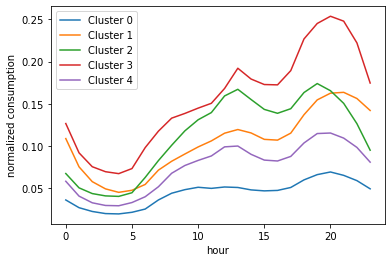

In [175]:
#clustering centers Fuzzy C-Means
for x in range(0,5,1):
        plt.plot(fuzzy[0][x],label = "Cluster " + str(x))  
        plt.legend()
        plt.ylabel("normalized consumption")
        plt.xlabel("hour")

# Improvment of validation indices calculations

In [194]:
#improvement in % of SIL
0.778/0.4779

1.6279556392550745

In [193]:
#decrease in % of DBI wit different normalization
1 - 0.3572/0.8500

0.579764705882353